In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette('dark')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Load the dataset
df = pd.read_csv('/kaggle/input/tesla-data/Tasla_Stock_Updated_V2.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Check data types
print("\nData Types:")
print(df.dtypes)

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values)

Dataset Shape: (2274, 7)

First 5 rows:
   Unnamed: 0        Date       Open       High        Low      Close  \
0           0  2015-01-02  14.858000  14.883333  14.217333  14.620667   
1           1  2015-01-05  14.303333  14.433333  13.810667  14.006000   
2           2  2015-01-06  14.004000  14.280000  13.614000  14.085333   
3           3  2015-01-07  14.223333  14.318667  13.985333  14.063333   
4           4  2015-01-08  14.187333  14.253333  14.000667  14.041333   

     Volume  
0  71466000  
1  80527500  
2  93928500  
3  44526000  
4  51637500  

Data Types:
Unnamed: 0      int64
Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume          int64
dtype: object

Summary Statistics:
        Unnamed: 0         Open         High          Low        Close  \
count  2274.000000  2274.000000  2274.000000  2274.000000  2274.000000   
mean   1136.500000   103.493730   105.771617   101.036327   103.461794   
std     656.5

In [2]:
# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df = df.set_index('Date')
df = df.sort_index()

# Check for duplicates
duplicate_dates = df.index.duplicated().sum()
print(f"\nNumber of duplicate dates: {duplicate_dates}")

# Handle missing values if any
if df.isnull().sum().sum() > 0:
    print("Filling missing values...")
    # For numeric columns, fill with median
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    # Forward fill any remaining
    df = df.ffill()
    
    # Check if any missing values remain
    if df.isnull().sum().sum() > 0:
        print("Dropping remaining rows with missing values...")
        df = df.dropna()

# Display the data range
print(f"\nData Range: {df.index.min()} to {df.index.max()}")
print(f"Total Trading Days: {len(df)}")

# Check for outliers in each column
print("\nChecking for outliers (Z-score > 3):")
for col in df.select_dtypes(include=['number']).columns:
    z_scores = np.abs(stats.zscore(df[col]))
    outliers = (z_scores > 3).sum()
    if outliers > 0:
        print(f"{col}: {outliers} outliers ({outliers/len(df)*100:.2f}%)")


Number of duplicate dates: 0

Data Range: 2015-01-02 00:00:00 to 2024-01-16 00:00:00
Total Trading Days: 2274

Checking for outliers (Z-score > 3):
Volume: 44 outliers (1.93%)


In [3]:
# Create additional features for analysis
print("\nCreating additional features...")

# Daily returns
df['Daily_Return'] = df['Close'].pct_change()
# Replace inf values with NaN
df['Daily_Return'] = df['Daily_Return'].replace([np.inf, -np.inf], np.nan)

# Weekly returns
df['Weekly_Return'] = df['Close'].pct_change(5)  # Assuming 5 trading days in a week

# Monthly returns
df['Monthly_Return'] = df['Close'].pct_change(21)  # Approx. 21 trading days in a month

# Moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Volatility (rolling standard deviation)
df['Volatility_5d'] = df['Close'].rolling(window=5).std()
df['Volatility_20d'] = df['Close'].rolling(window=20).std()

# Trading range
df['Range'] = df['High'] - df['Low']
df['Range_Pct'] = df['Range'] / df['Open'] * 100  # Range as percentage of opening price

# Volume indicators
df['Avg_Volume_20d'] = df['Volume'].rolling(window=20).mean()
df['Volume_Change'] = df['Volume'].pct_change()
df['Volume_Change'] = df['Volume_Change'].replace([np.inf, -np.inf], np.nan)

# Relative Strength Index (RSI) - simplified calculation
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'], 14)

# Print the head with new features
print("\nFirst 5 rows with new features:")
print(df.head())

# Drop rows with NaN values resulting from calculations
df_clean = df.dropna()
print(f"\nShape after dropping NaN values: {df_clean.shape}")


Creating additional features...

First 5 rows with new features:
            Unnamed: 0       Open       High        Low      Close    Volume  \
Date                                                                           
2015-01-02           0  14.858000  14.883333  14.217333  14.620667  71466000   
2015-01-05           1  14.303333  14.433333  13.810667  14.006000  80527500   
2015-01-06           2  14.004000  14.280000  13.614000  14.085333  93928500   
2015-01-07           3  14.223333  14.318667  13.985333  14.063333  44526000   
2015-01-08           4  14.187333  14.253333  14.000667  14.041333  51637500   

            Daily_Return  Weekly_Return  Monthly_Return        MA5  MA20  \
Date                                                                       
2015-01-02           NaN            NaN             NaN        NaN   NaN   
2015-01-05     -0.042041            NaN             NaN        NaN   NaN   
2015-01-06      0.005664            NaN             NaN        NaN   

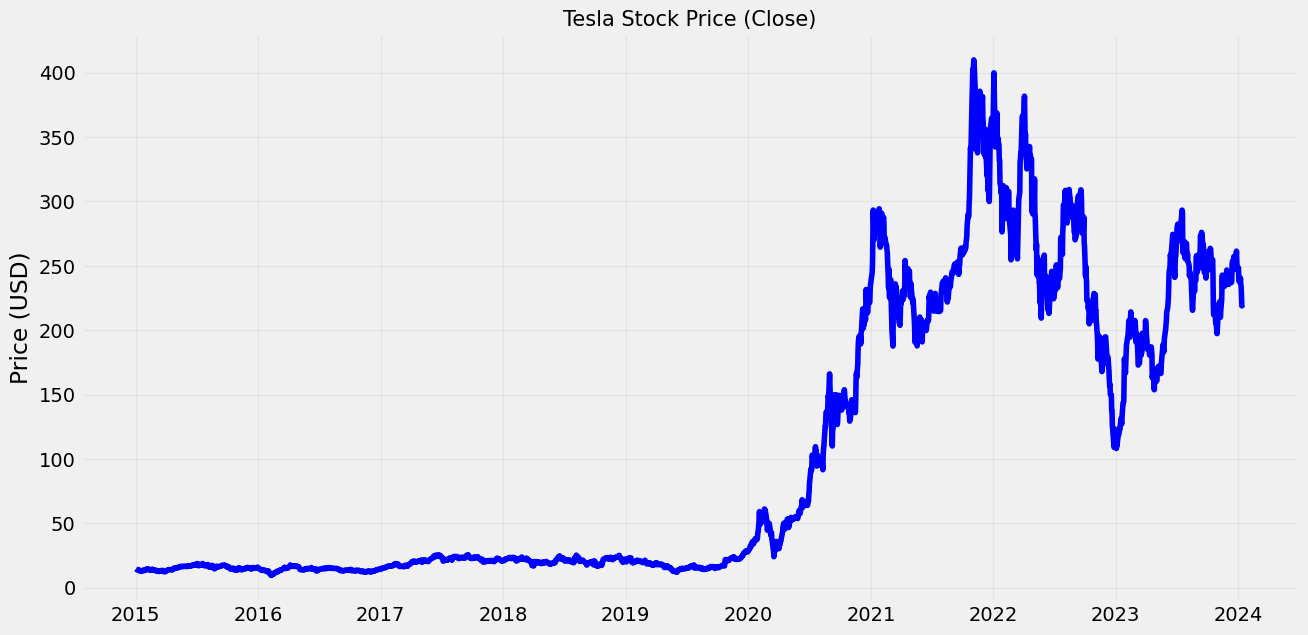

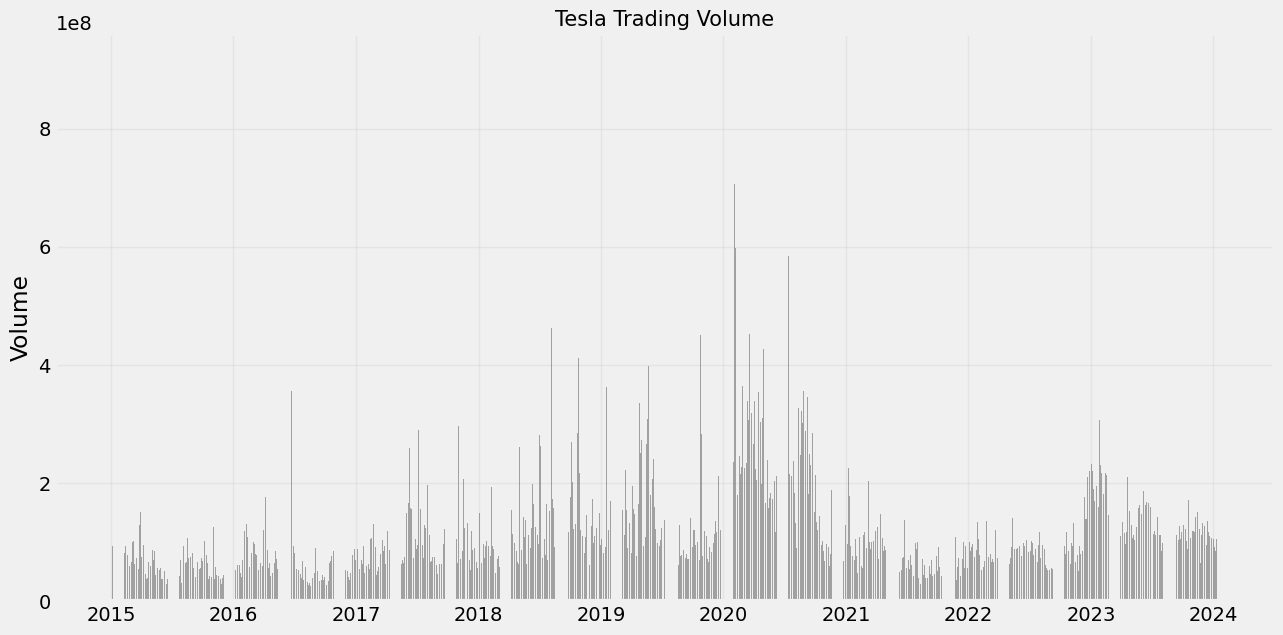

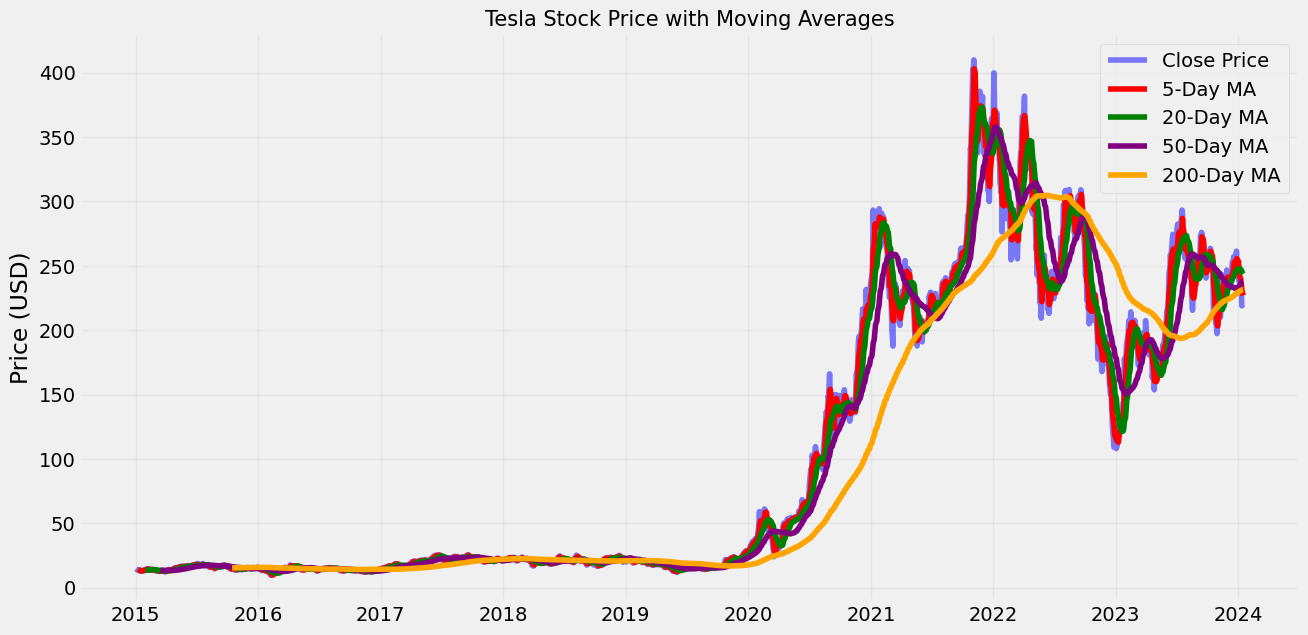

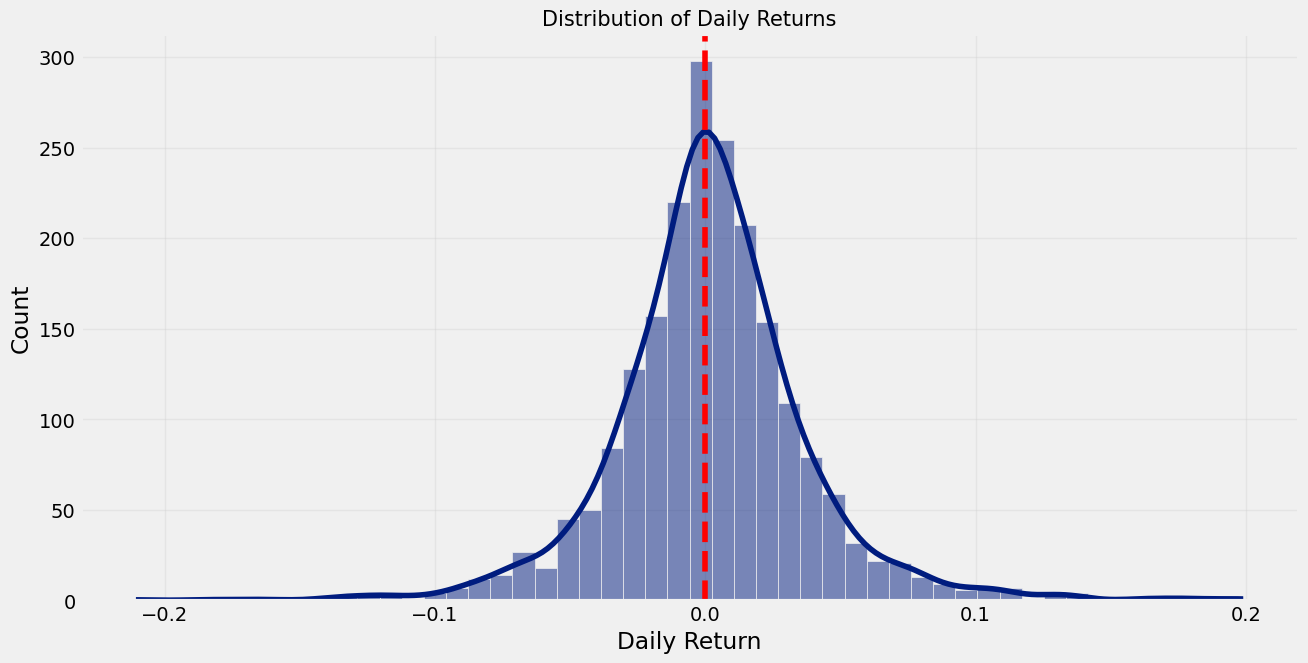

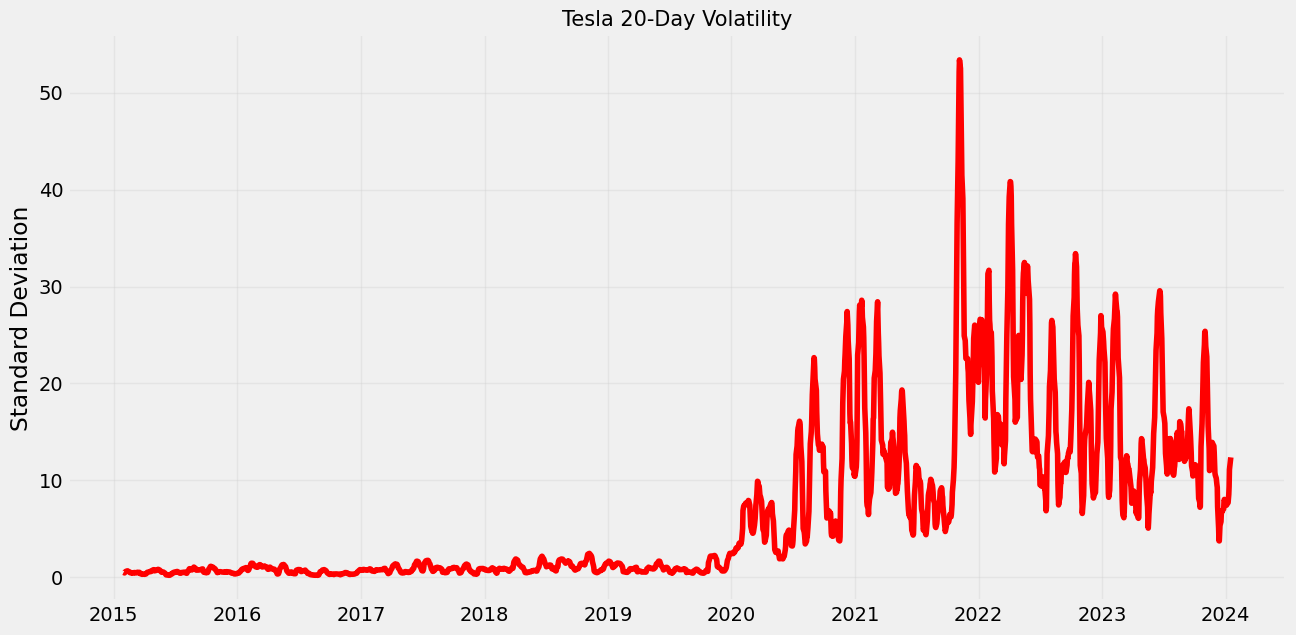

In [4]:
# Plotting closing price over time
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], color='blue')
plt.title('Tesla Stock Price (Close)', fontsize=15)
plt.ylabel('Price (USD)')
plt.grid(True, alpha=0.3)
plt.show()

# Plot volume over time
plt.figure(figsize=(14, 7))
plt.bar(df.index, df['Volume'], color='gray', alpha=0.7)
plt.title('Tesla Trading Volume', fontsize=15)
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)
plt.show()

# Plot closing price with moving averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', alpha=0.5, color='blue')
plt.plot(df['MA5'], label='5-Day MA', color='red')
plt.plot(df['MA20'], label='20-Day MA', color='green')
plt.plot(df['MA50'], label='50-Day MA', color='purple')
plt.plot(df['MA200'], label='200-Day MA', color='orange')
plt.title('Tesla Stock Price with Moving Averages', fontsize=15)
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Daily returns distribution
plt.figure(figsize=(14, 7))
sns.histplot(df_clean['Daily_Return'], kde=True, bins=50)
plt.title('Distribution of Daily Returns', fontsize=15)
plt.xlabel('Daily Return')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

# Volatility over time
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility_20d'], color='red')
plt.title('Tesla 20-Day Volatility', fontsize=15)
plt.ylabel('Standard Deviation')
plt.grid(True, alpha=0.3)
plt.show()

Returns Statistics:
             Daily       Weekly      Monthly
count  2075.000000  2075.000000  2075.000000
mean      0.001965     0.010163     0.045314
std       0.036435     0.085068     0.196789
min      -0.210628    -0.430459    -0.579194
25%      -0.016192    -0.039019    -0.081964
50%       0.001313     0.006870     0.019849
75%       0.019257     0.053416     0.135773
max       0.198949     0.564756     1.087066


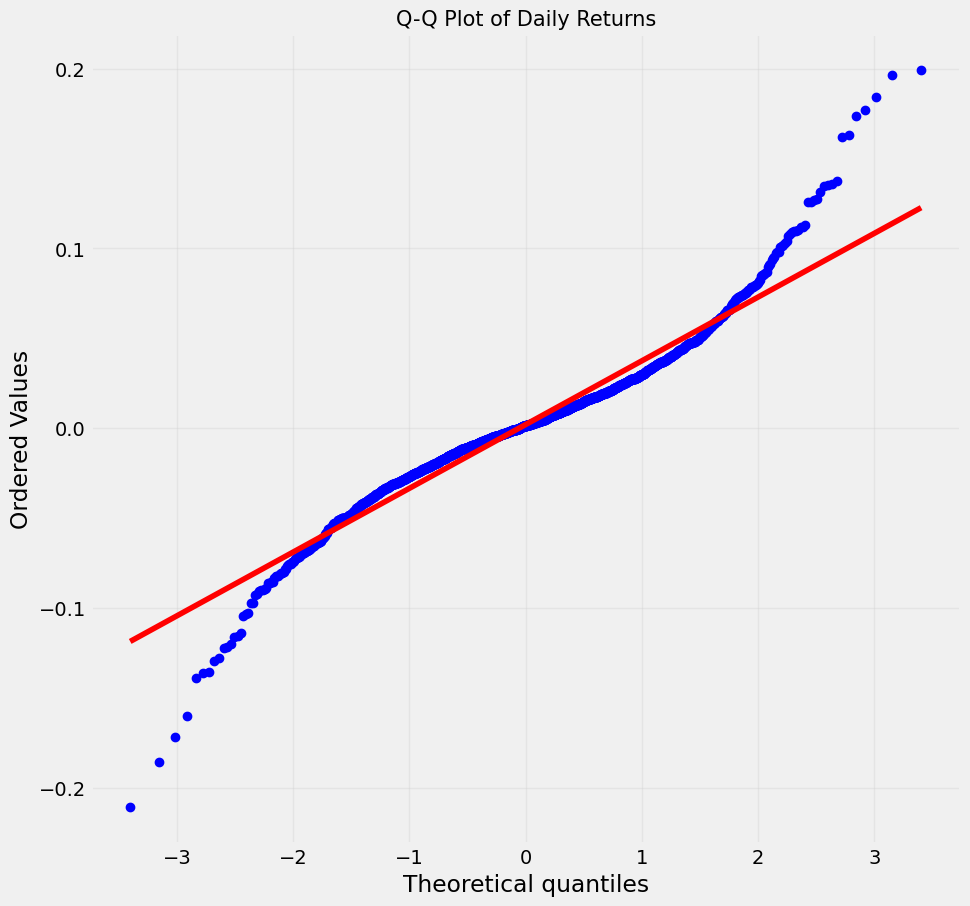


Skewness of Daily Returns: 0.1797
Kurtosis of Daily Returns: 4.1724

Shapiro-Wilk Test for Normality of Daily Returns:
W-statistic: 0.9460
p-value: 0.0000000000
The daily returns are not normally distributed (reject H0)


In [5]:
# Statistical summary of returns
returns_stats = pd.DataFrame({
    'Daily': df_clean['Daily_Return'].describe(),
    'Weekly': df_clean['Weekly_Return'].describe(),
    'Monthly': df_clean['Monthly_Return'].describe()
})
print("Returns Statistics:")
print(returns_stats)

# Check for normality of returns (QQ plot)
plt.figure(figsize=(10, 10))
stats.probplot(df_clean['Daily_Return'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Daily Returns', fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

# Calculate skewness and kurtosis
skewness = df_clean['Daily_Return'].skew()
kurtosis = df_clean['Daily_Return'].kurt()
print(f"\nSkewness of Daily Returns: {skewness:.4f}")
print(f"Kurtosis of Daily Returns: {kurtosis:.4f}")

# Check for normality using statistical test
shapiro_test = stats.shapiro(df_clean['Daily_Return'].dropna())
print(f"\nShapiro-Wilk Test for Normality of Daily Returns:")
print(f"W-statistic: {shapiro_test[0]:.4f}")
print(f"p-value: {shapiro_test[1]:.10f}")
if shapiro_test[1] < 0.05:
    print("The daily returns are not normally distributed (reject H0)")
else:
    print("The daily returns are normally distributed (fail to reject H0)")

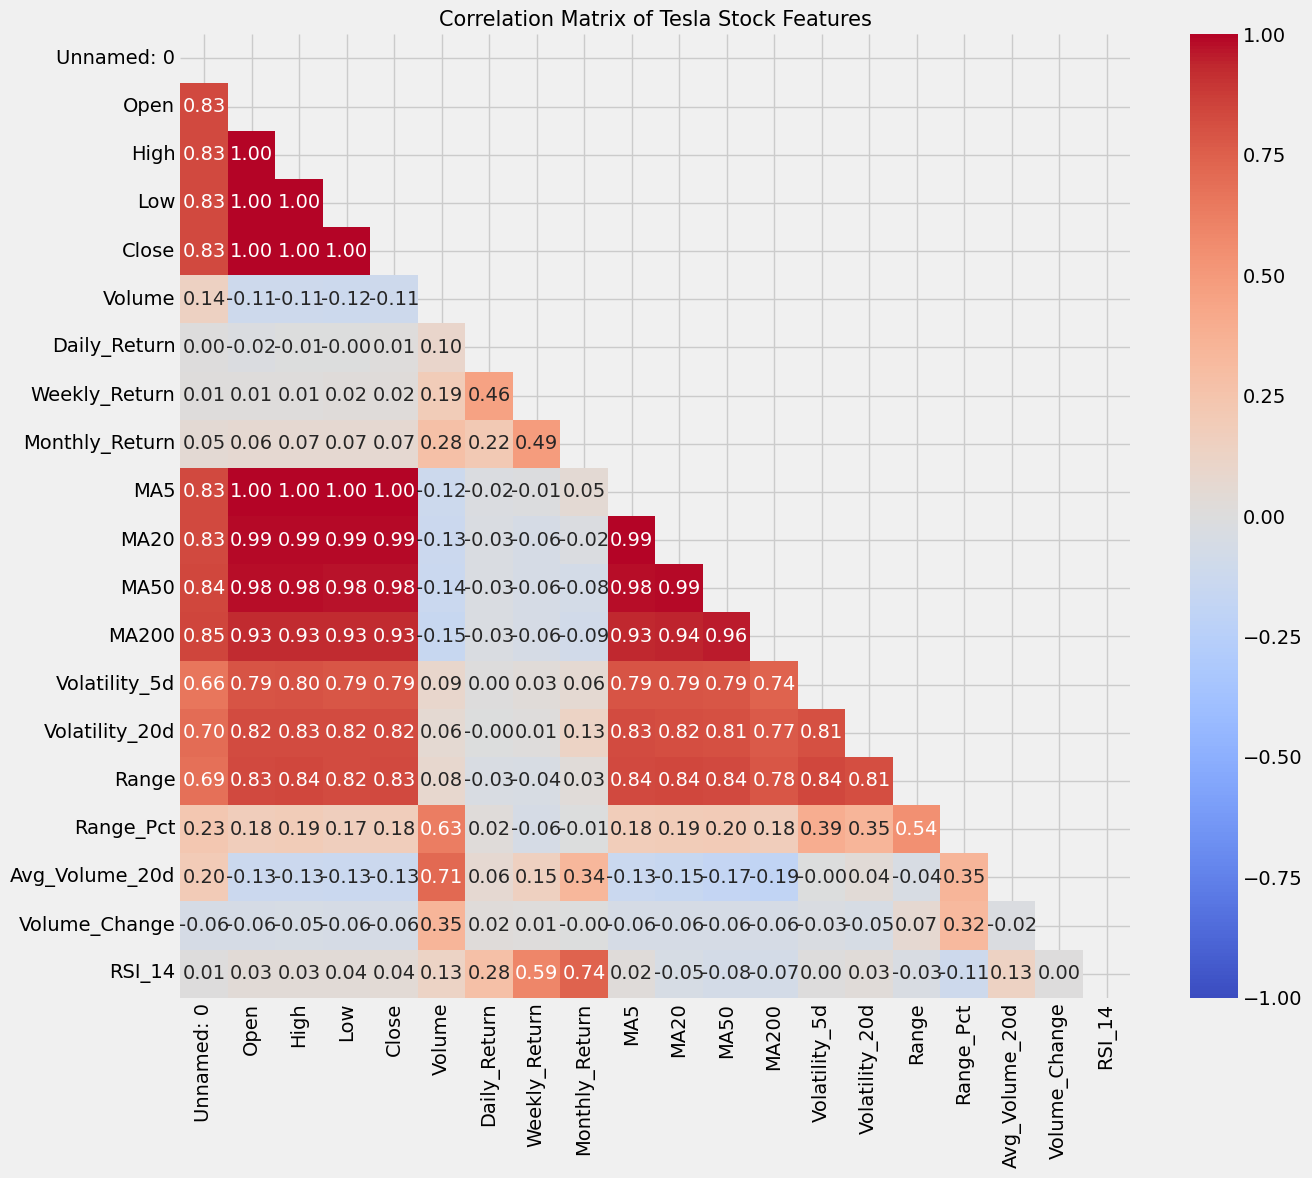

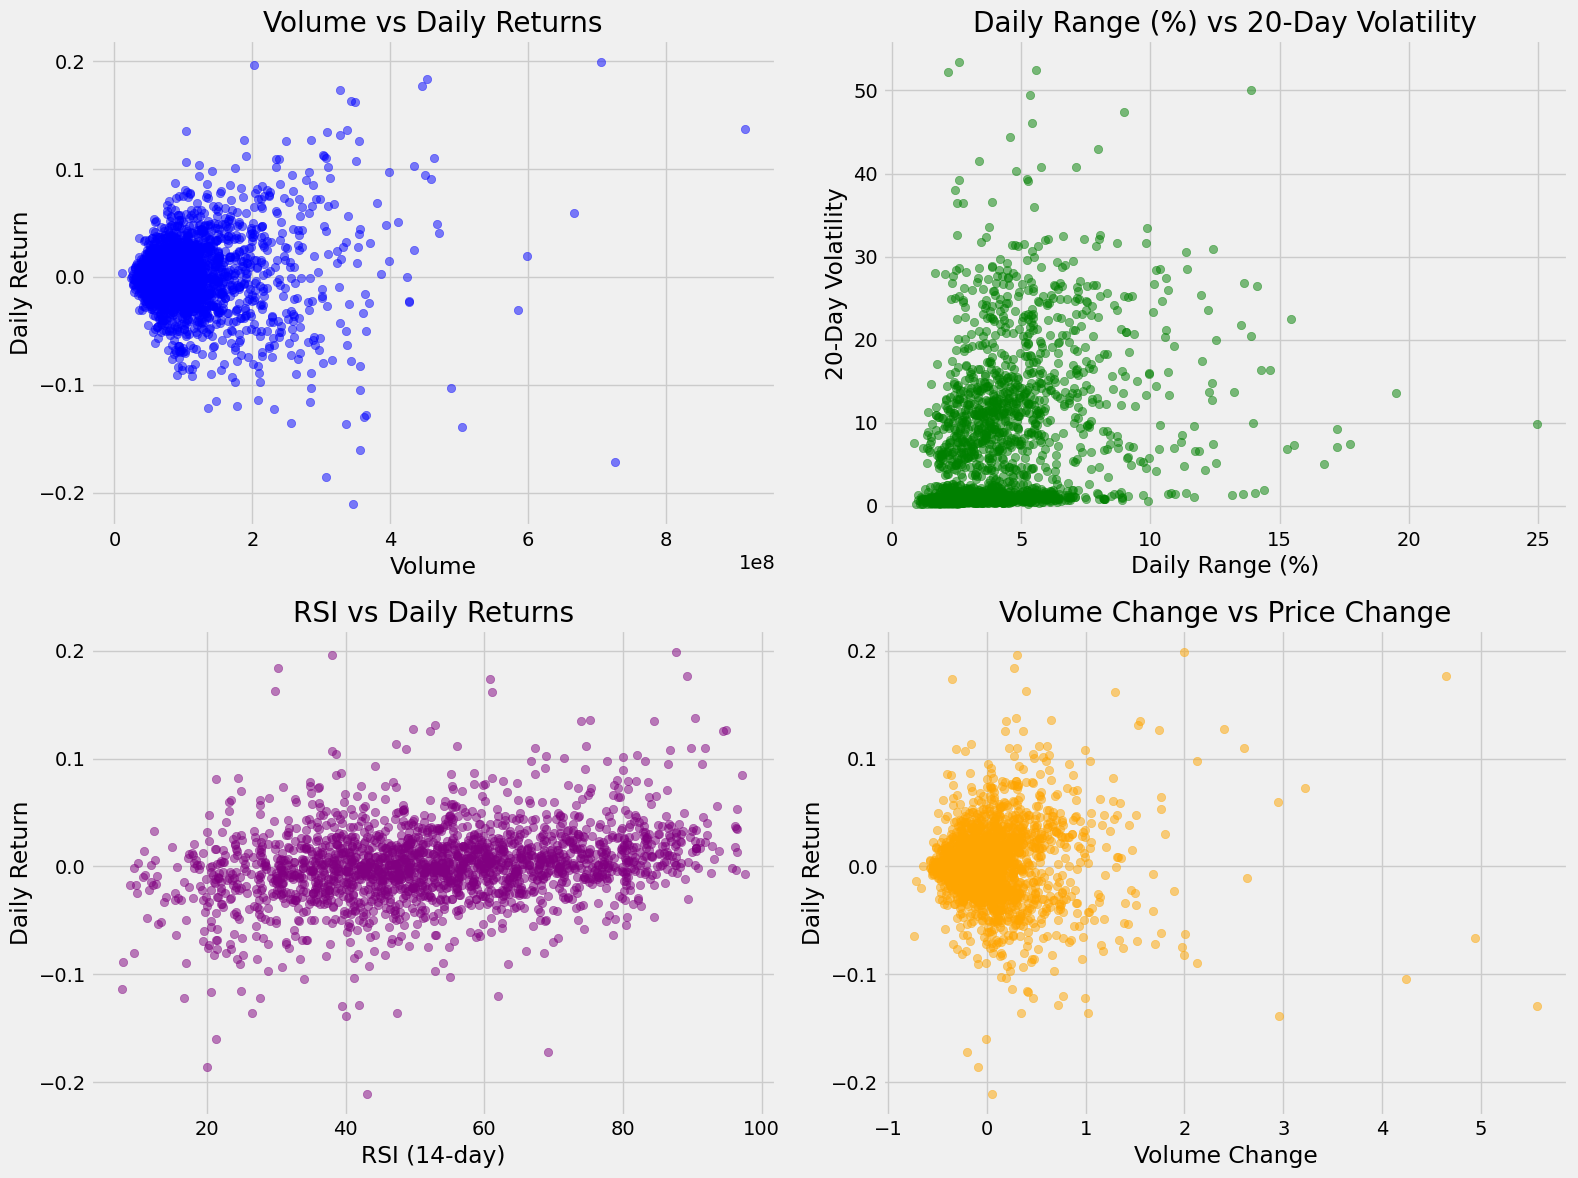

In [6]:
# Correlation matrix
correlation = df_clean.corr()
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Tesla Stock Features', fontsize=15)
plt.tight_layout()
plt.show()

# Scatter plot of key relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Volume vs Daily Returns
axes[0, 0].scatter(df_clean['Volume'], df_clean['Daily_Return'], alpha=0.5, color='blue')
axes[0, 0].set_title('Volume vs Daily Returns')
axes[0, 0].set_xlabel('Volume')
axes[0, 0].set_ylabel('Daily Return')

# Range vs Volatility
axes[0, 1].scatter(df_clean['Range_Pct'], df_clean['Volatility_20d'], alpha=0.5, color='green')
axes[0, 1].set_title('Daily Range (%) vs 20-Day Volatility')
axes[0, 1].set_xlabel('Daily Range (%)')
axes[0, 1].set_ylabel('20-Day Volatility')

# RSI vs Daily Returns
axes[1, 0].scatter(df_clean['RSI_14'], df_clean['Daily_Return'], alpha=0.5, color='purple')
axes[1, 0].set_title('RSI vs Daily Returns')
axes[1, 0].set_xlabel('RSI (14-day)')
axes[1, 0].set_ylabel('Daily Return')

# Volume Change vs Price Change
axes[1, 1].scatter(df_clean['Volume_Change'], df_clean['Daily_Return'], alpha=0.5, color='orange')
axes[1, 1].set_title('Volume Change vs Price Change')
axes[1, 1].set_xlabel('Volume Change')
axes[1, 1].set_ylabel('Daily Return')

plt.tight_layout()
plt.show()

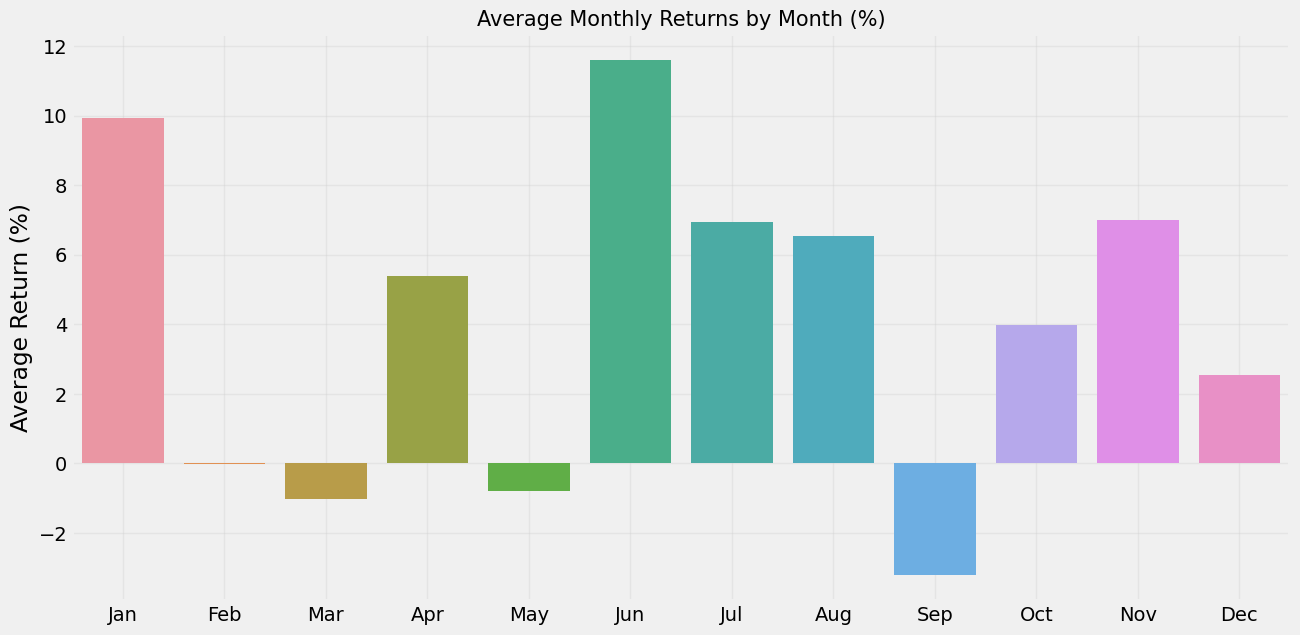

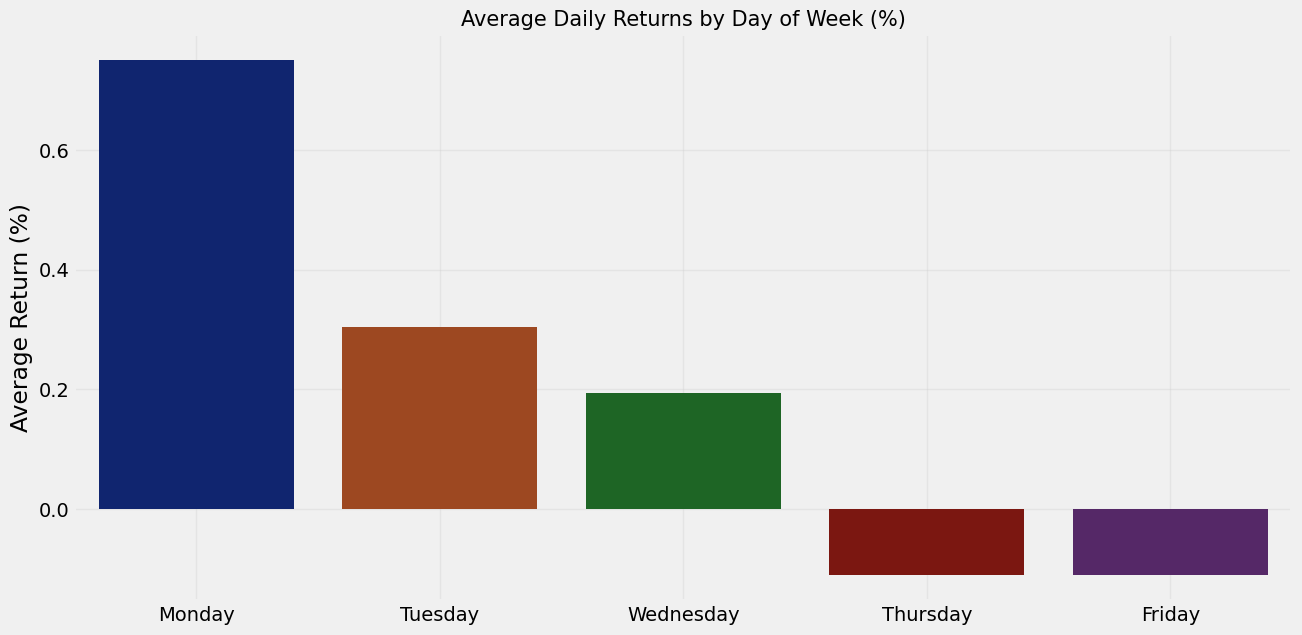

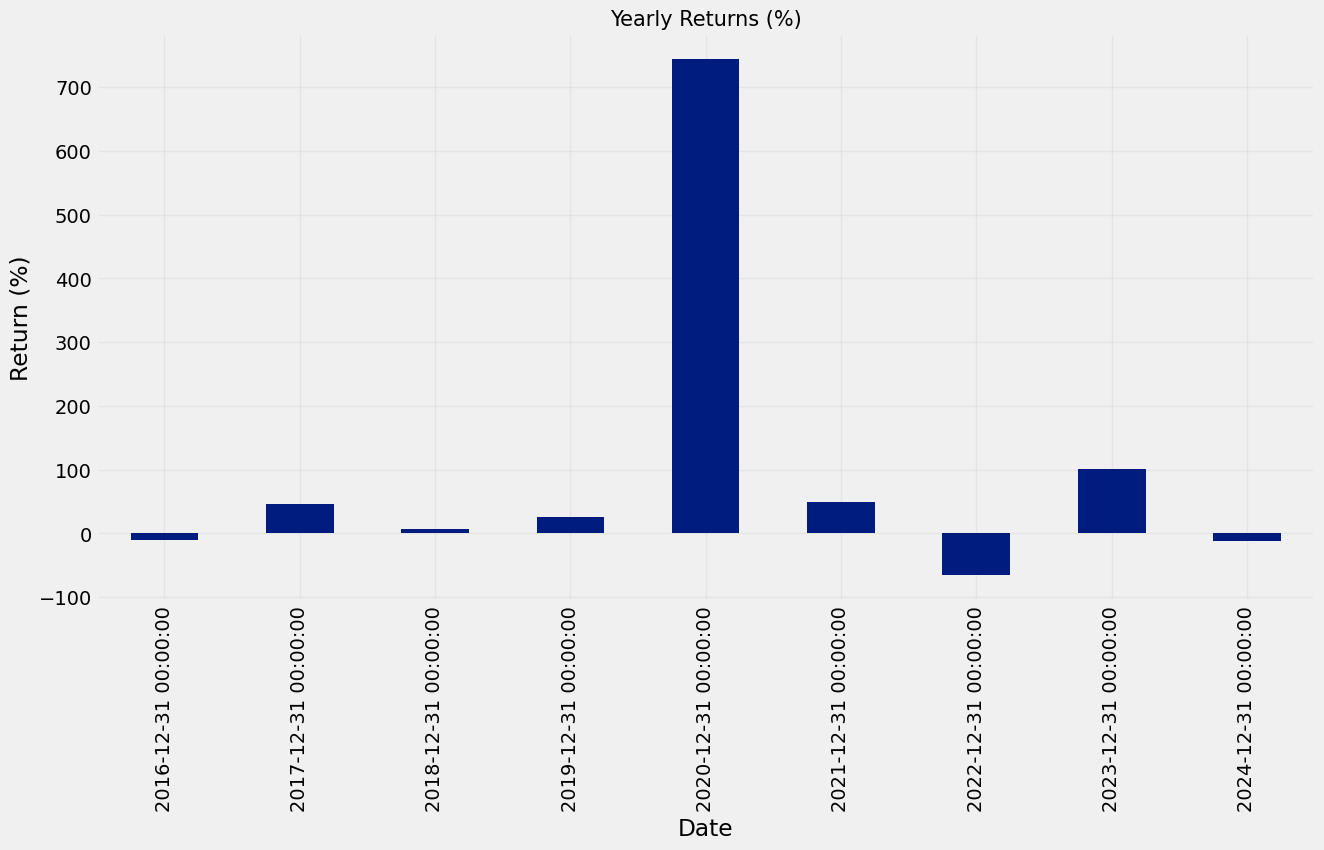

In [7]:
# Resample to monthly data for seasonality analysis
monthly_data = df['Close'].resample('ME').last()
monthly_returns = monthly_data.pct_change().dropna()

# Monthly seasonality
monthly_returns_by_month = monthly_returns.groupby(monthly_returns.index.month).mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(14, 7))
sns.barplot(x=months, y=monthly_returns_by_month.values * 100)
plt.title('Average Monthly Returns by Month (%)', fontsize=15)
plt.ylabel('Average Return (%)')
plt.grid(True, alpha=0.3)
plt.show()

# Day of week analysis
daily_returns_by_day = df_clean['Daily_Return'].groupby(df_clean.index.dayofweek).mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

plt.figure(figsize=(14, 7))
sns.barplot(x=days, y=daily_returns_by_day.values * 100)
plt.title('Average Daily Returns by Day of Week (%)', fontsize=15)
plt.ylabel('Average Return (%)')
plt.grid(True, alpha=0.3)
plt.show()

# Yearly performance
yearly_returns = df['Close'].resample('Y').last().pct_change().dropna() * 100
plt.figure(figsize=(14, 7))
yearly_returns.plot(kind='bar')
plt.title('Yearly Returns (%)', fontsize=15)
plt.ylabel('Return (%)')
plt.grid(True, alpha=0.3)
plt.show()

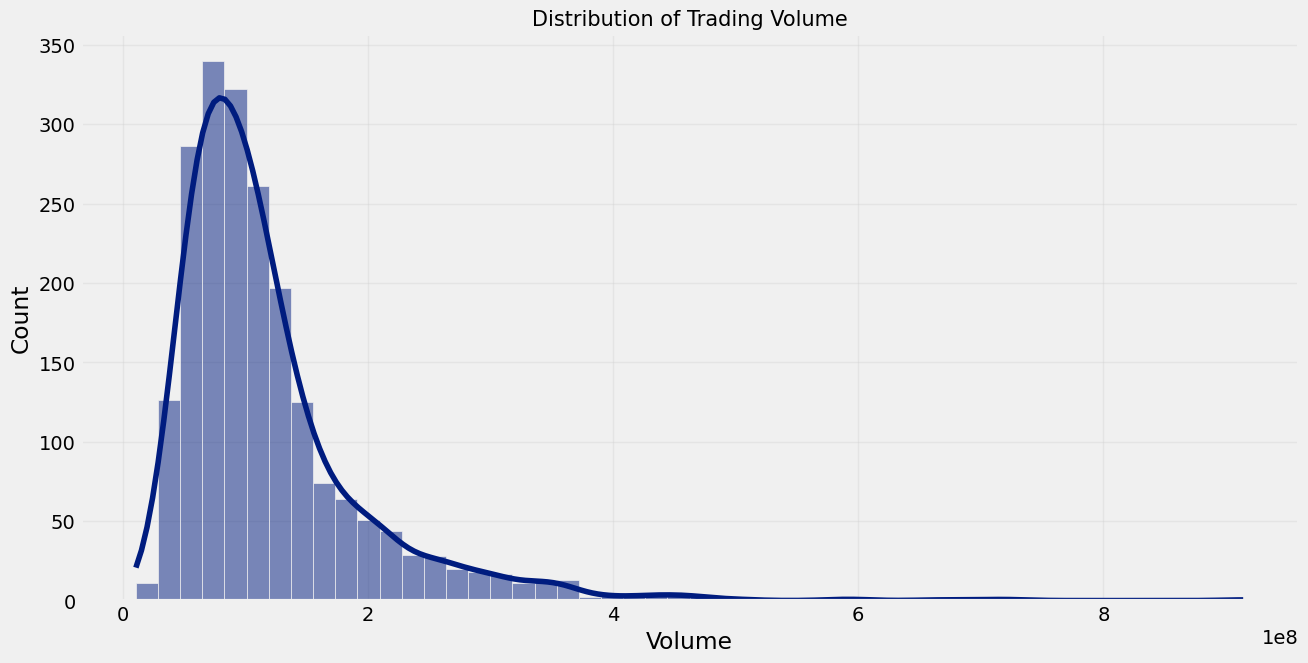

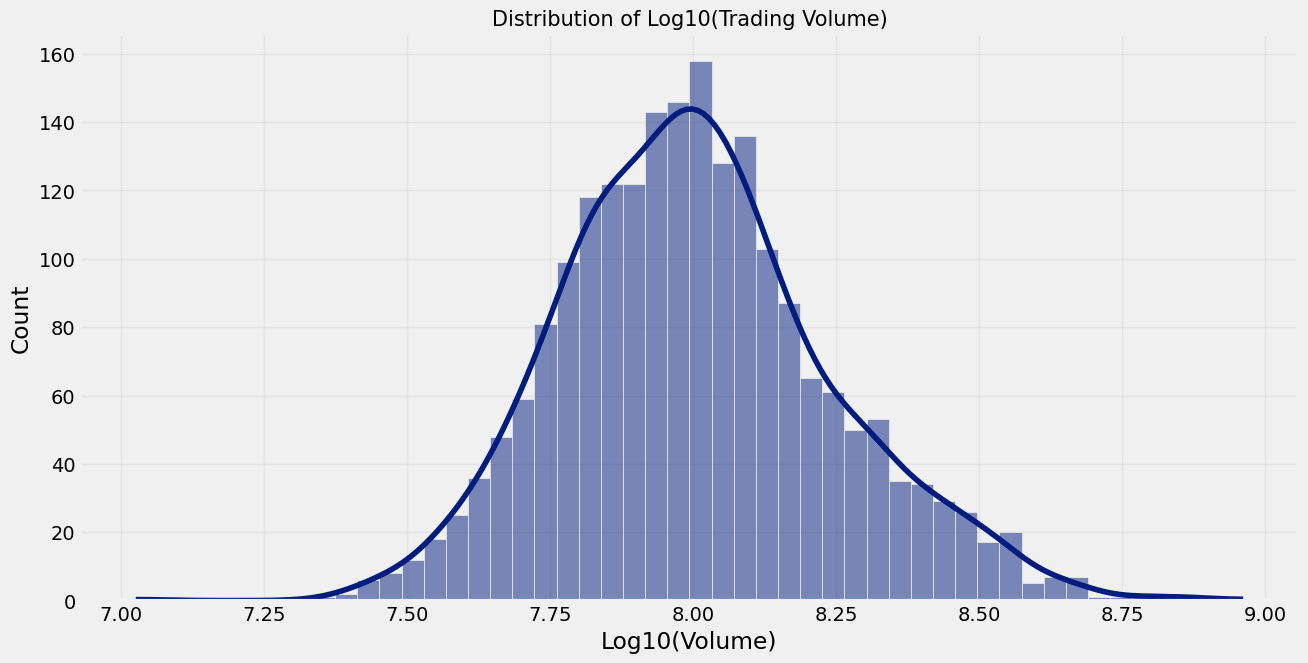

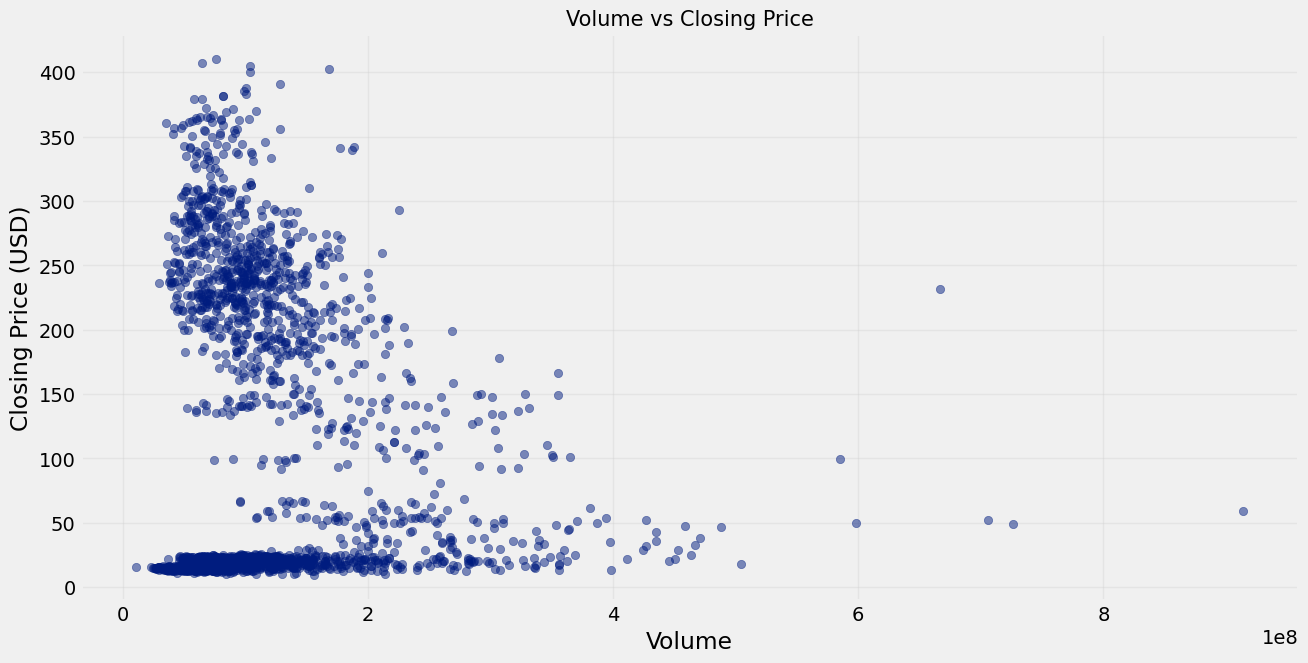

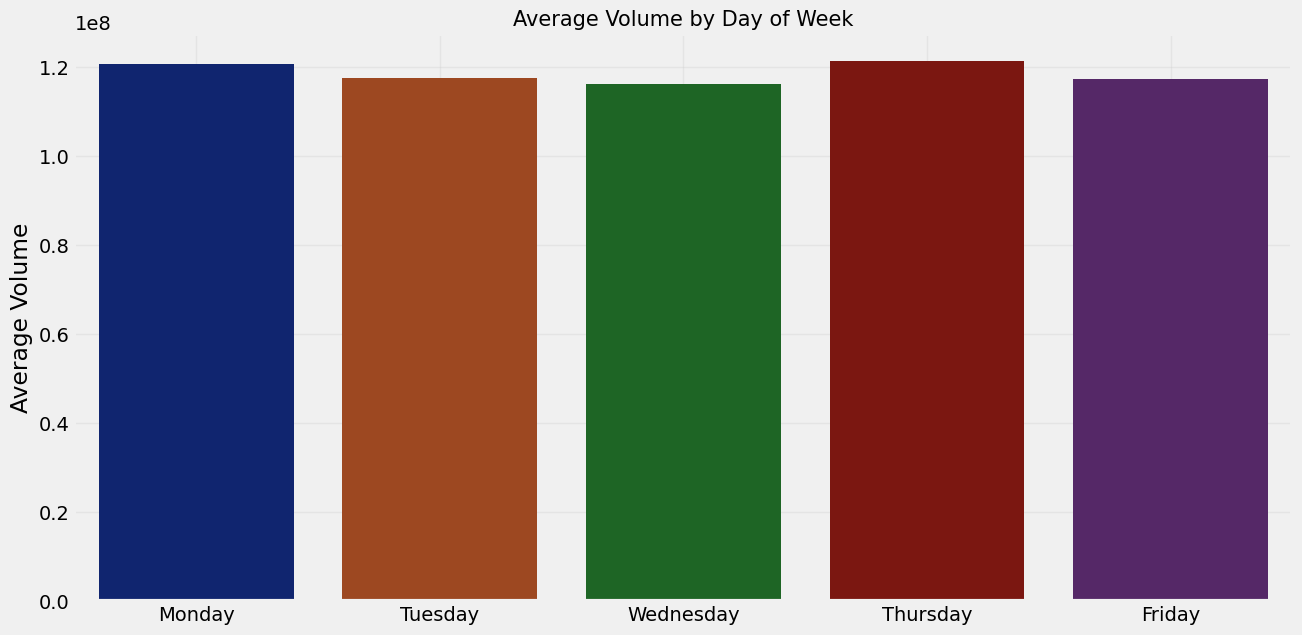

In [8]:
# Volume distribution
plt.figure(figsize=(14, 7))
sns.histplot(df_clean['Volume'], kde=True, bins=50)
plt.title('Distribution of Trading Volume', fontsize=15)
plt.xlabel('Volume')
plt.grid(True, alpha=0.3)
plt.show()

# Log volume for better visualization
plt.figure(figsize=(14, 7))
sns.histplot(np.log10(df_clean['Volume']), kde=True, bins=50)
plt.title('Distribution of Log10(Trading Volume)', fontsize=15)
plt.xlabel('Log10(Volume)')
plt.grid(True, alpha=0.3)
plt.show()

# Volume vs Price
plt.figure(figsize=(14, 7))
plt.scatter(df_clean['Volume'], df_clean['Close'], alpha=0.5)
plt.title('Volume vs Closing Price', fontsize=15)
plt.xlabel('Volume')
plt.ylabel('Closing Price (USD)')
plt.grid(True, alpha=0.3)
plt.show()

# Volume by day of week
volume_by_day = df_clean['Volume'].groupby(df_clean.index.dayofweek).mean()
plt.figure(figsize=(14, 7))
sns.barplot(x=days, y=volume_by_day.values)
plt.title('Average Volume by Day of Week', fontsize=15)
plt.ylabel('Average Volume')
plt.grid(True, alpha=0.3)
plt.show()

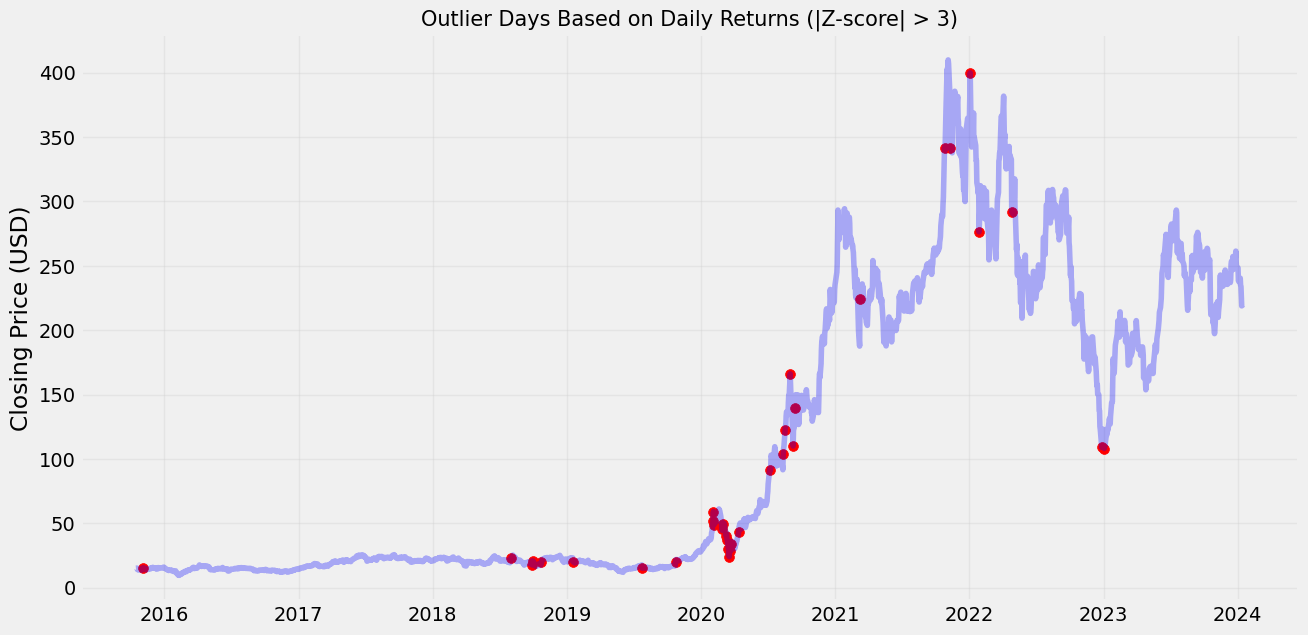


Extreme Price Movements (>99th percentile):
                 Date       Close  Daily_Return     Volume
Date                                                      
2020-02-03 2020-02-03   52.000000     19.894859  705975000
2021-03-09 2021-03-09  224.526672     19.641208  202569900
2020-03-19 2020-03-19   28.509333     18.387684  452932500
2019-10-24 2019-10-24   19.978666     17.669232  445813500
2018-10-01 2018-10-01   20.713333     17.347133  326664000
2020-03-24 2020-03-24   33.666668     16.281749  343428000
2018-08-02 2018-08-02   23.302668     16.188013  348225000
2020-02-04 2020-02-04   59.137333     13.725640  914082000
2020-04-13 2020-04-13   43.396667     13.603839  337131000
2022-01-03 2022-01-03  399.926666     13.531668  103931400
2020-07-06 2020-07-06   91.438667     13.479394  308548500
2020-08-12 2020-08-12  103.650665     13.123639  327441000
2018-10-23 2018-10-23   19.609333     12.718905  285417000
2021-10-25 2021-10-25  341.619995     12.661598  188556300
2020-09-14 

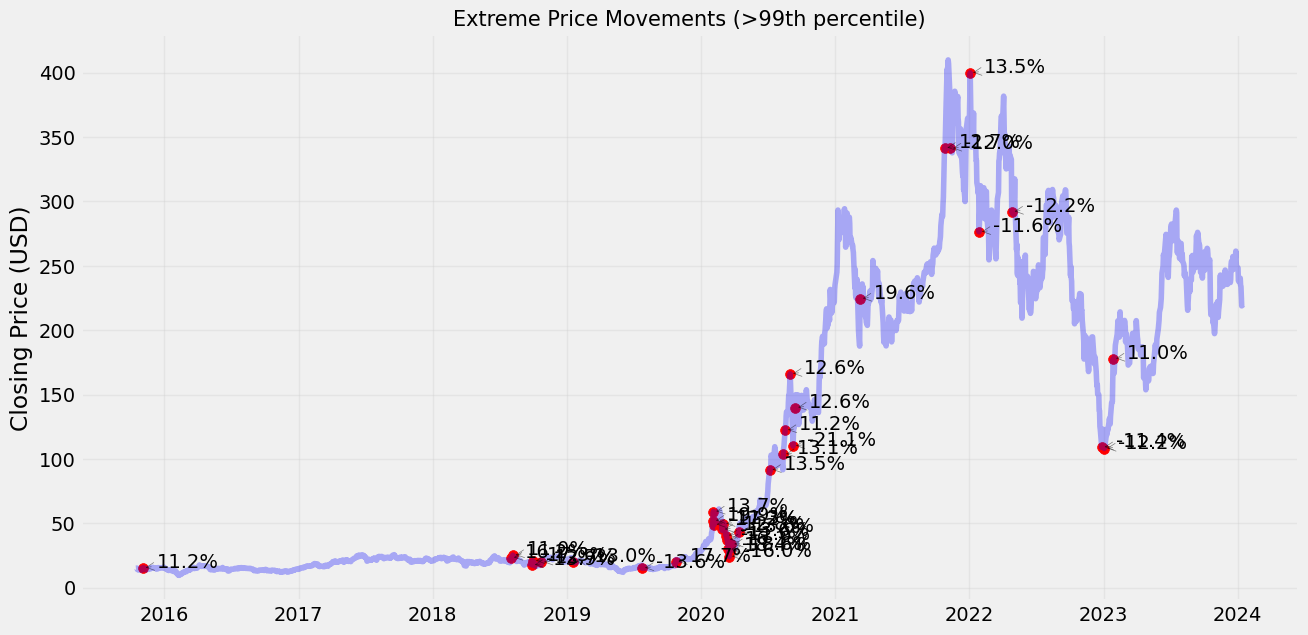

In [9]:
# Identify outliers in daily returns using Z-scores
z_scores = np.abs(stats.zscore(df_clean['Daily_Return']))
outliers = df_clean[z_scores > 3]

plt.figure(figsize=(14, 7))
plt.plot(df_clean['Close'], alpha=0.3, color='blue')
plt.scatter(outliers.index, outliers['Close'], color='red', s=50)
plt.title('Outlier Days Based on Daily Returns (|Z-score| > 3)', fontsize=15)
plt.ylabel('Closing Price (USD)')
plt.grid(True, alpha=0.3)
plt.show()

# Identify extreme price movements
extreme_returns = df_clean[np.abs(df_clean['Daily_Return']) > df_clean['Daily_Return'].quantile(0.99)]
print("\nExtreme Price Movements (>99th percentile):")
extreme_events = pd.DataFrame({
    'Date': extreme_returns.index,
    'Close': extreme_returns['Close'],
    'Daily_Return': extreme_returns['Daily_Return'] * 100,
    'Volume': extreme_returns['Volume']
})
print(extreme_events.sort_values('Daily_Return', ascending=False))

# Plot the extreme events
plt.figure(figsize=(14, 7))
plt.plot(df_clean['Close'], alpha=0.3, color='blue')
plt.scatter(extreme_returns.index, extreme_returns['Close'], color='red', s=50)
for date, row in extreme_returns.iterrows():
    plt.annotate(f"{row['Daily_Return']*100:.1f}%", 
                xy=(date, row['Close']),
                xytext=(10, 0),
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color='black', alpha=0.5))
plt.title('Extreme Price Movements (>99th percentile)', fontsize=15)
plt.ylabel('Closing Price (USD)')
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 1400x700 with 0 Axes>

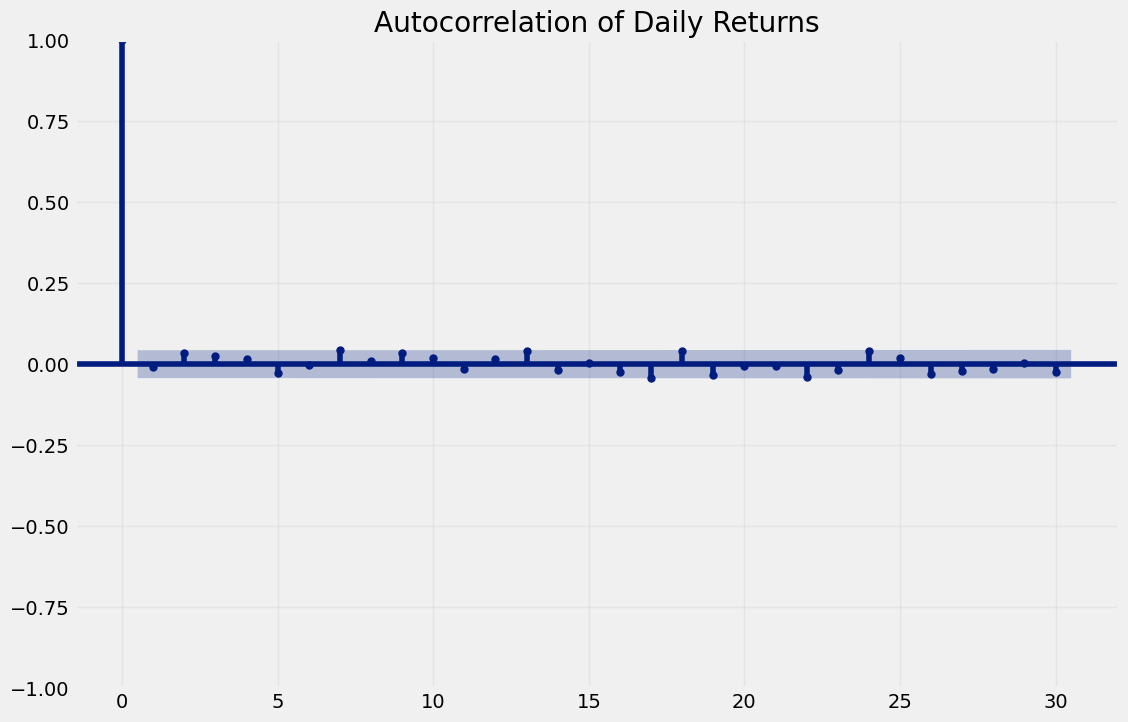

<Figure size 1400x700 with 0 Axes>

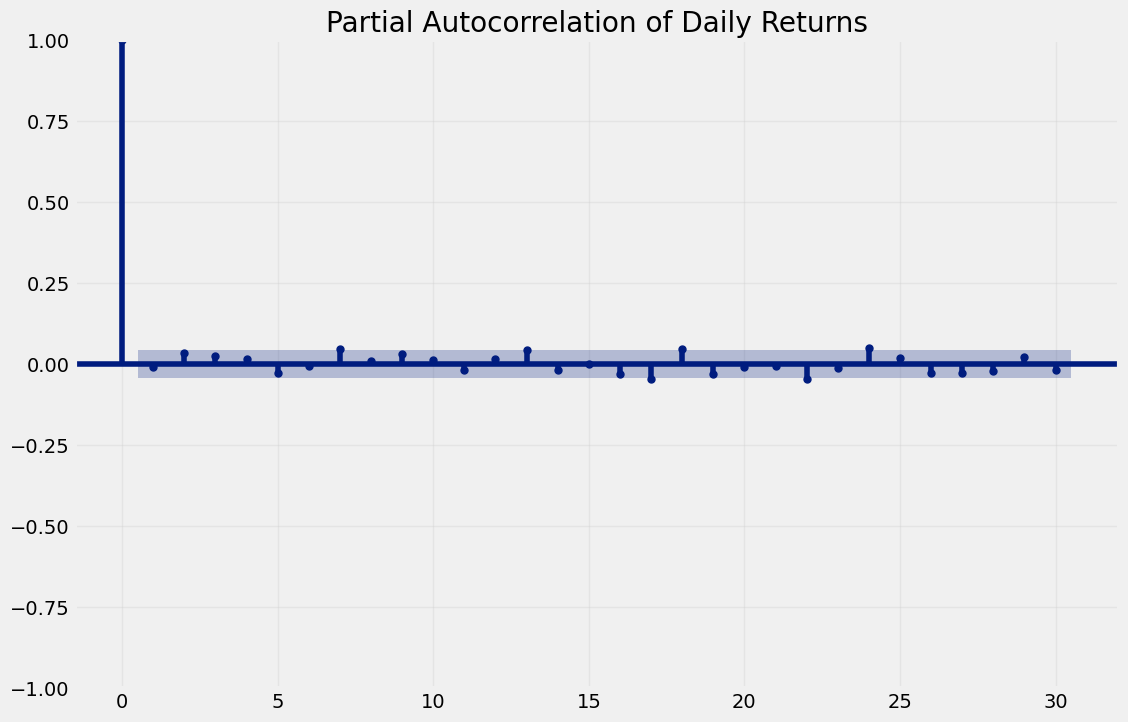

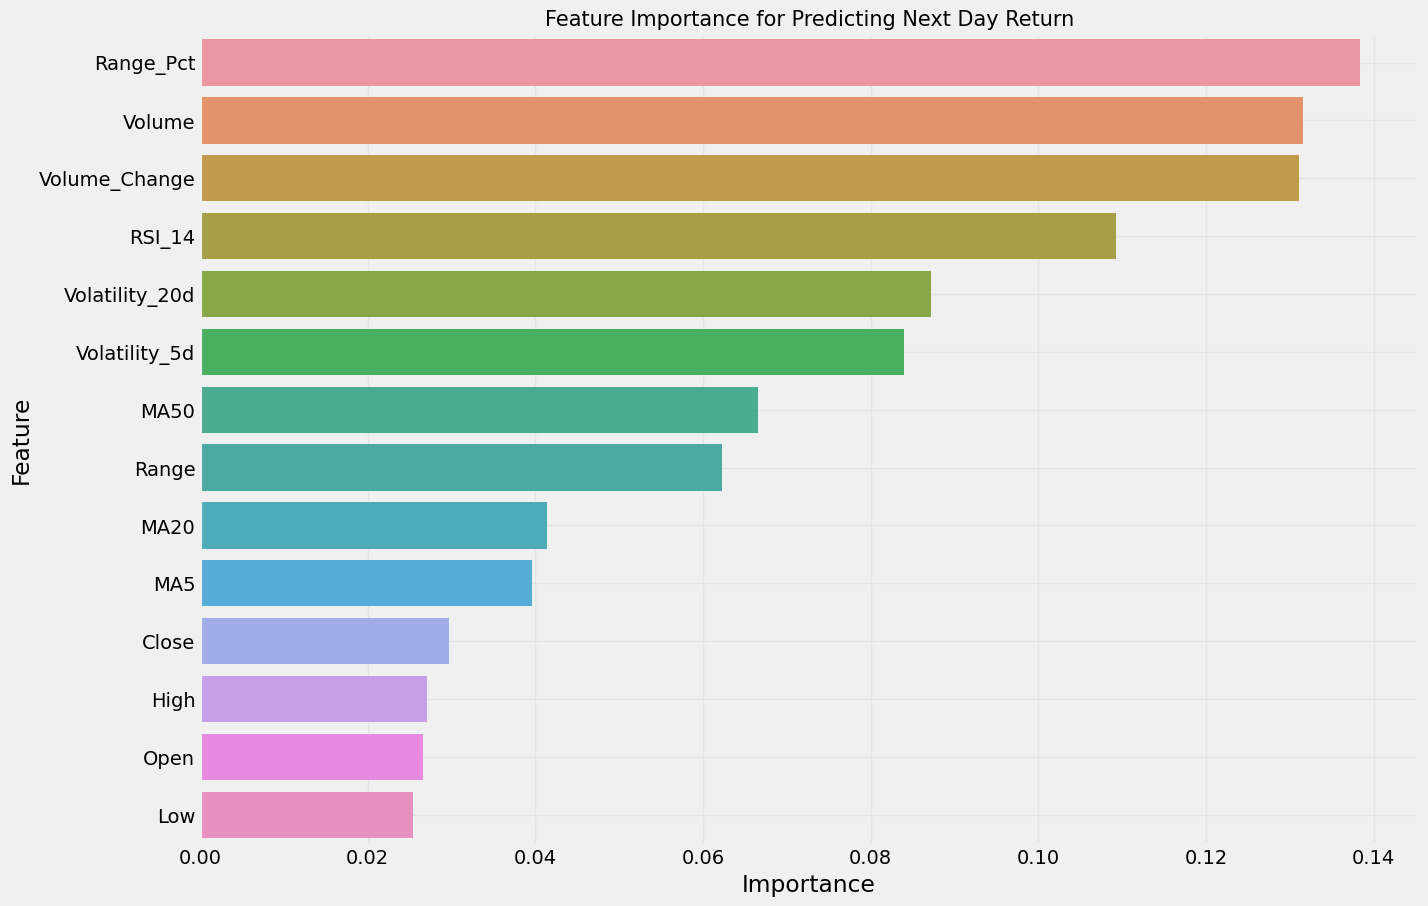

Root Mean Squared Error for Predicting Next Day Returns: 0.037623


In [10]:
# Auto-correlation analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 7))
plot_acf(df_clean['Daily_Return'].dropna(), lags=30, title='Autocorrelation of Daily Returns')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 7))
plot_pacf(df_clean['Daily_Return'].dropna(), lags=30, title='Partial Autocorrelation of Daily Returns')
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance for predicting next day's return
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 
           'MA5', 'MA20', 'MA50', 'Volatility_5d', 'Volatility_20d', 
           'Range', 'Range_Pct', 'RSI_14', 'Volume_Change']

# Shift target to predict next day's return
df_clean['Next_Day_Return'] = df_clean['Daily_Return'].shift(-1)
df_ml = df_clean.dropna().copy()

X = df_ml[features]
y = df_ml['Next_Day_Return']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Predicting Next Day Return', fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

# Model performance
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error for Predicting Next Day Returns: {rmse:.6f}")

In [11]:
# Summarize key statistics and findings
print("\n===================== TESLA STOCK EDA SUMMARY =====================")
print(f"Data Range: {df.index.min()} to {df.index.max()} ({len(df)} trading days)")
print(f"Price Range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
print(f"Average Daily Return: {df_clean['Daily_Return'].mean()*100:.4f}%")
print(f"Average Trading Volume: {df_clean['Volume'].mean():.0f}")
print(f"Average 20-Day Volatility: {df_clean['Volatility_20d'].mean():.4f}")
print(f"Most Volatile Day: {df_clean['Volatility_20d'].idxmax()} ({df_clean['Volatility_20d'].max():.4f})")
print(f"Day with Highest Return: {df_clean['Daily_Return'].idxmax()} ({df_clean['Daily_Return'].max()*100:.2f}%)")
print(f"Day with Lowest Return: {df_clean['Daily_Return'].idxmin()} ({df_clean['Daily_Return'].min()*100:.2f}%)")
print(f"Day with Highest Volume: {df_clean['Volume'].idxmax()} ({df_clean['Volume'].max():.0f})")
print("=================================================================")

# Additional insights based on analysis
print("\nKey Insights from EDA:")
print("1. Return Distribution: Daily returns appear to be non-normally distributed with significant skewness and fat tails.")
print("2. Volatility Clusters: High volatility periods tend to cluster together.")
print(f"3. Seasonal Patterns: {months[monthly_returns_by_month.argmax()]} shows the highest average monthly return, while {months[monthly_returns_by_month.argmin()]} shows the lowest.")
print(f"4. Day of Week Effect: {days[daily_returns_by_day.argmax()]} has the highest average daily return, while {days[daily_returns_by_day.argmin()]} has the lowest.")
print("5. Volume-Price Relationship: Higher volumes often coincide with larger price movements, both up and down.")
print("6. Technical Indicators: RSI and moving average crossovers show potential predictive power for price movements.")
print("7. Feature Importance: Top 3 predictors for next day's return are:", ", ".join(feature_importance['Feature'].head(3).tolist()))


===================== TESLA STOCK EDA SUMMARY =====================
Data Range: 2015-01-02 00:00:00 to 2024-01-16 00:00:00 (2274 trading days)
Price Range: $9.58 - $409.97
Average Daily Return: 0.1965%
Average Trading Volume: 118648308
Average 20-Day Volatility: 7.2603
Most Volatile Day: 2021-11-05 00:00:00 (53.3801)
Day with Highest Return: 2020-02-03 00:00:00 (19.89%)
Day with Lowest Return: 2020-09-08 00:00:00 (-21.06%)
Day with Highest Volume: 2020-02-04 00:00:00 (914082000)

Key Insights from EDA:
1. Return Distribution: Daily returns appear to be non-normally distributed with significant skewness and fat tails.
2. Volatility Clusters: High volatility periods tend to cluster together.
3. Seasonal Patterns: Jun shows the highest average monthly return, while Sep shows the lowest.
4. Day of Week Effect: Monday has the highest average daily return, while Thursday has the lowest.
5. Volume-Price Relationship: Higher volumes often coincide with larger price movements, both up and down

Data range: 2015-01-02 00:00:00 to 2024-01-16 00:00:00
Total trading days: 2274


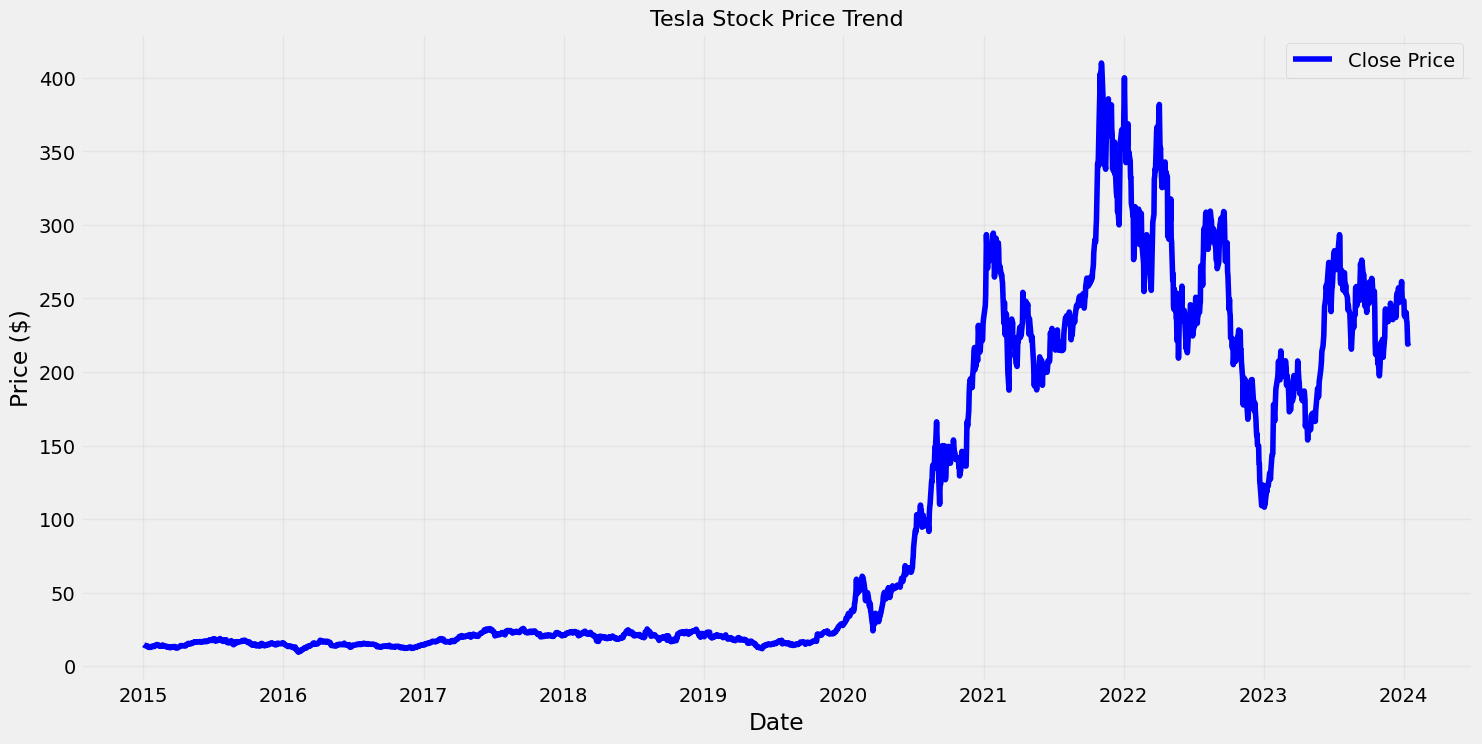

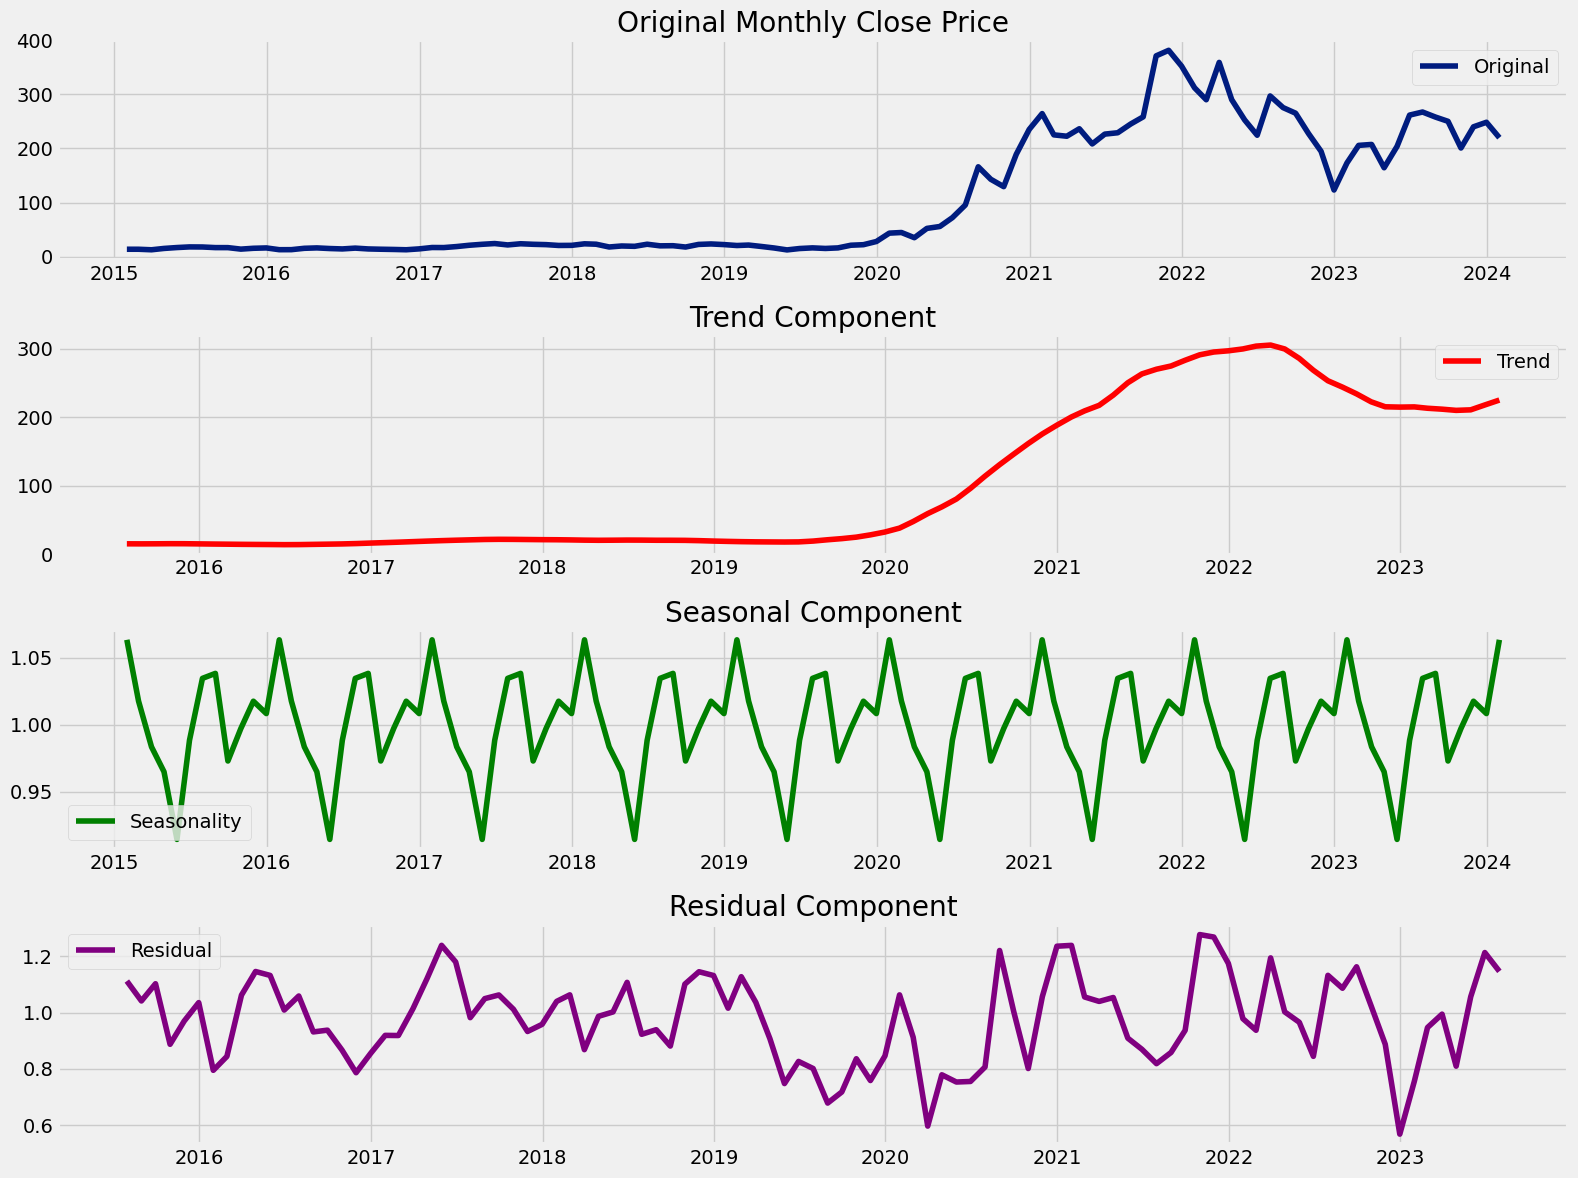

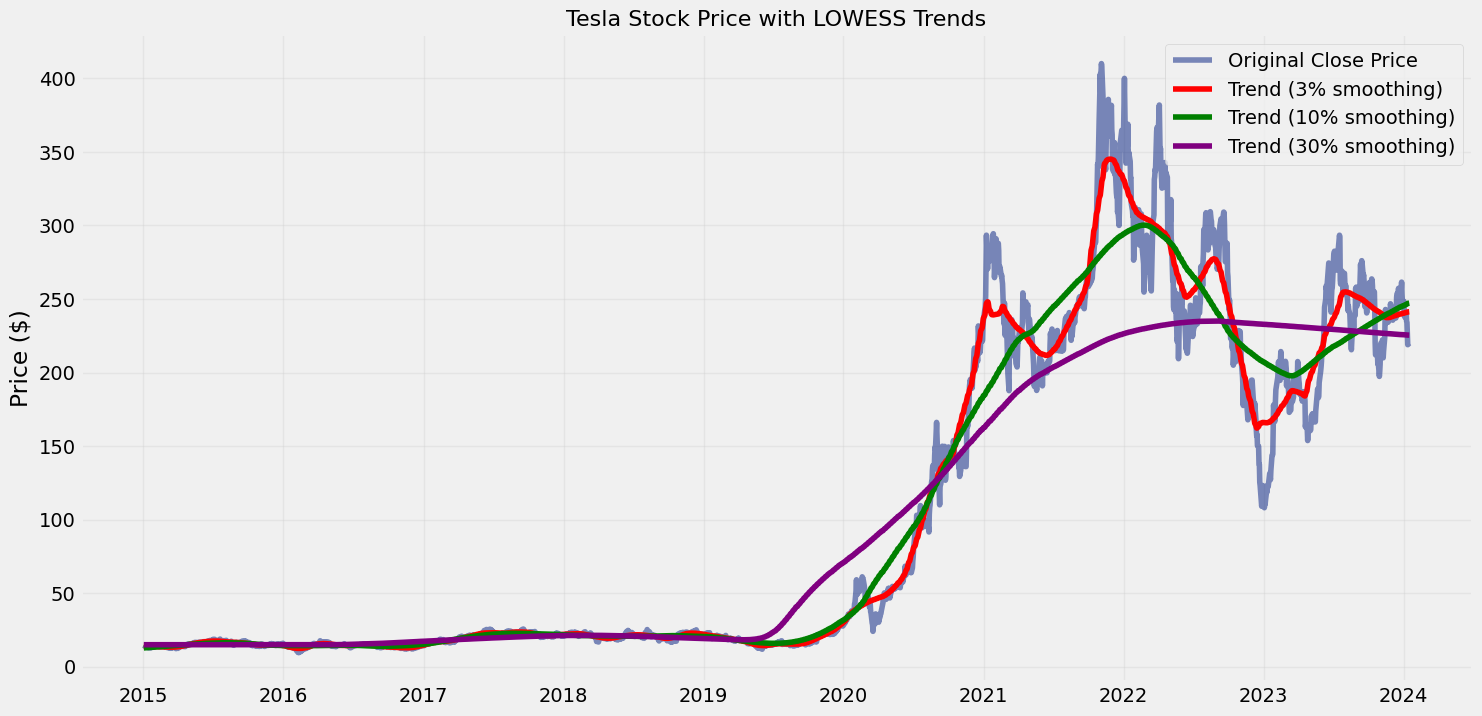

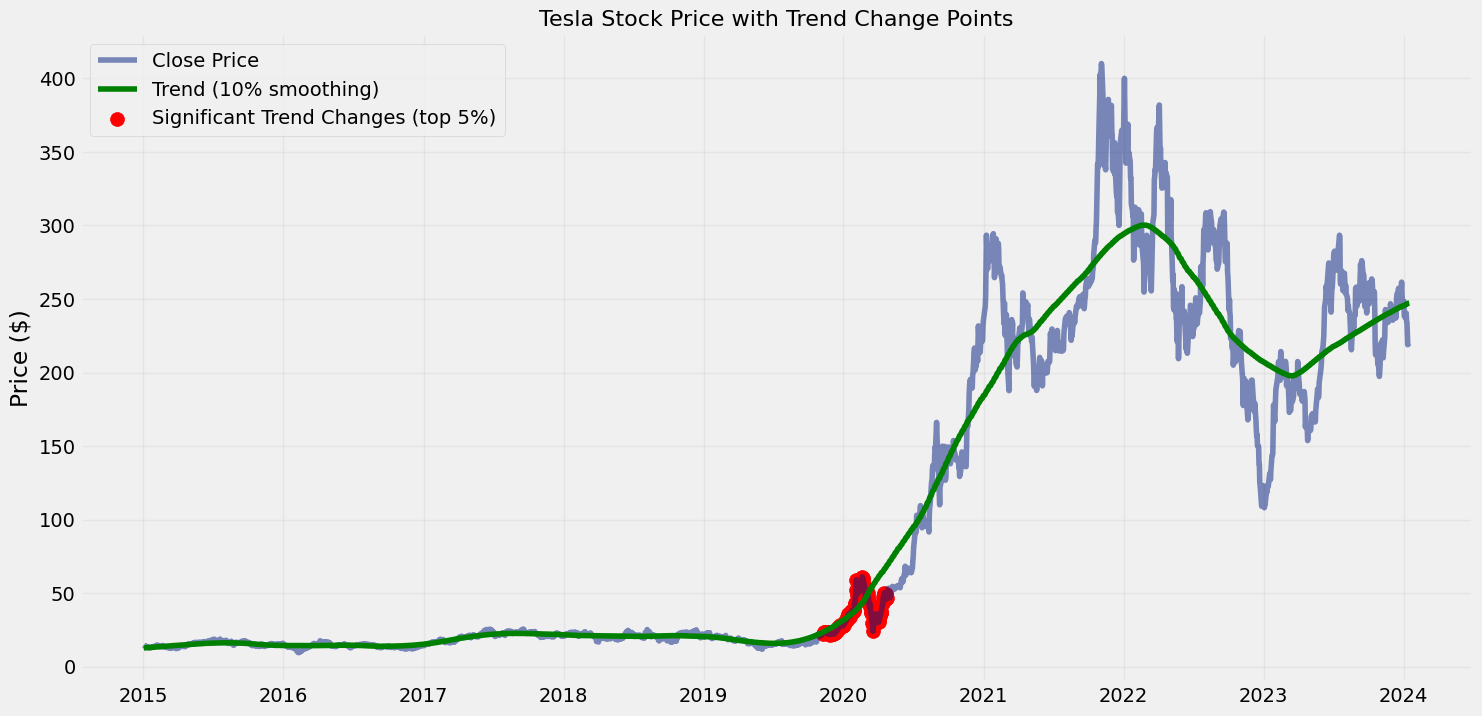

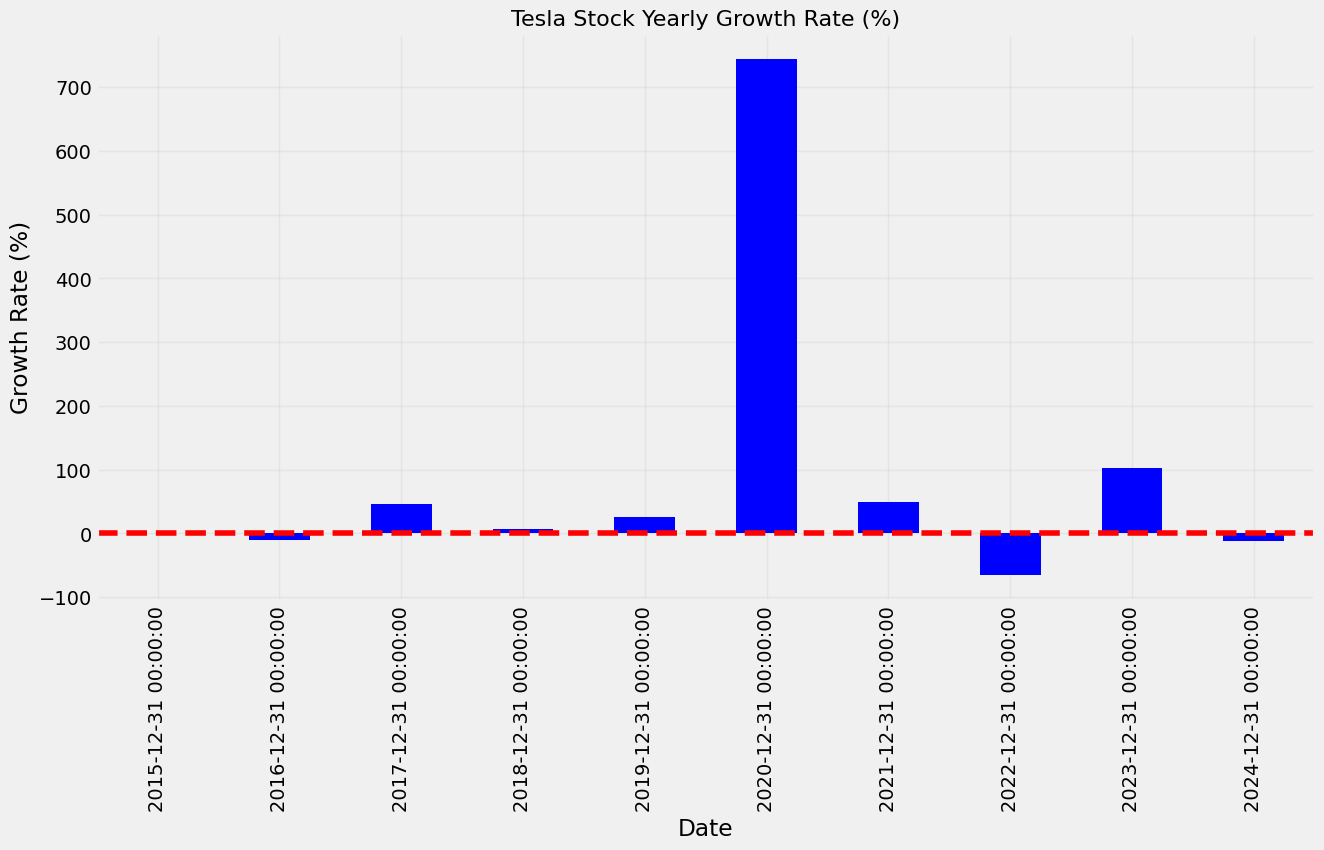

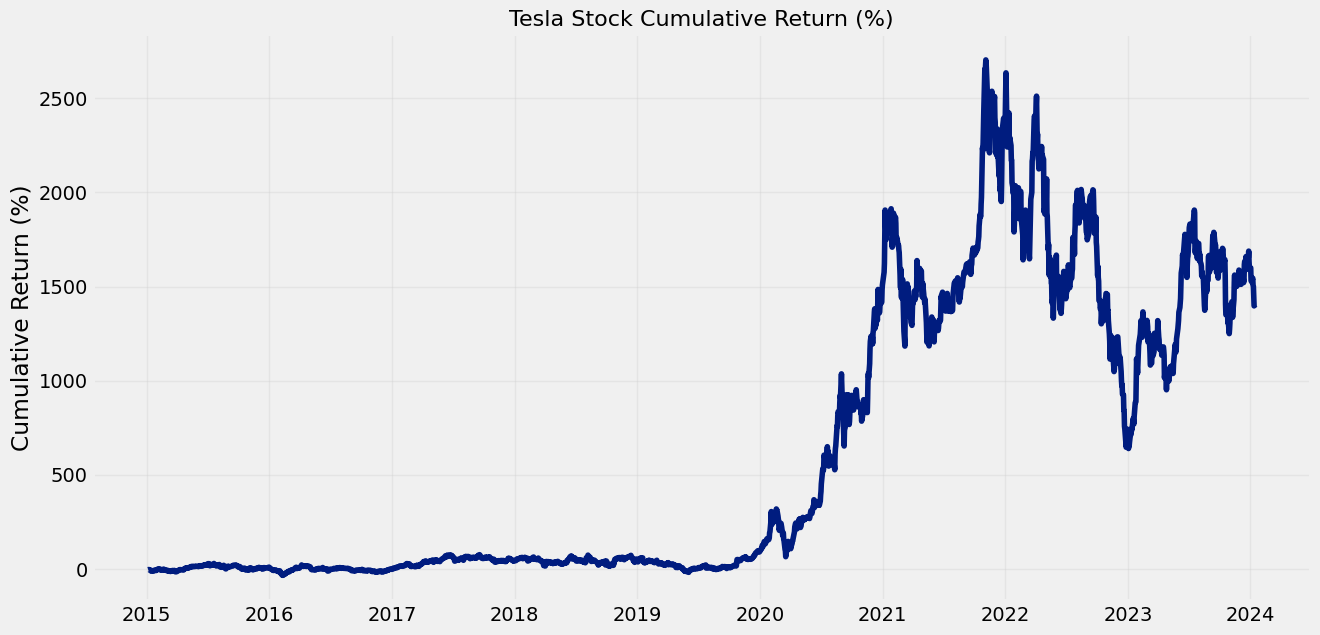

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette('dark')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 100

# Load the dataset
df = pd.read_csv('/kaggle/input/tesla-data/Tasla_Stock_Updated_V2.csv')

# Convert Date to datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.sort_index()

# Handle any missing values
if df.isnull().sum().sum() > 0:
    # For numeric columns, fill with median
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    # Forward fill any remaining
    df = df.ffill()
    
    # Drop any remaining rows with NaN
    df = df.dropna()

print(f"Data range: {df.index.min()} to {df.index.max()}")
print(f"Total trading days: {len(df)}")

# 1.1 Long-term trend visualization
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('Tesla Stock Price Trend', fontsize=16)
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 1.2 Decompose time series to extract trend component
# Resample to monthly data for clearer trend analysis
monthly_data = df['Close'].resample('ME').last()
result = seasonal_decompose(monthly_data, model='multiplicative', period=12)

plt.figure(figsize=(16, 12))

# Plot original data
plt.subplot(4, 1, 1)
plt.plot(monthly_data, label='Original')
plt.legend()
plt.title('Original Monthly Close Price')

# Plot trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='red')
plt.legend()
plt.title('Trend Component')

# Plot seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.legend()
plt.title('Seasonal Component')

# Plot residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='purple')
plt.legend()
plt.title('Residual Component')

plt.tight_layout()
plt.show()

# 1.3 LOWESS (Locally Weighted Scatterplot Smoothing) for trend analysis
# Convert index to numeric for LOWESS
x = np.array(range(len(df)))
y = df['Close'].values

# Calculate LOWESS trend with different smoothing parameters
lowess_03 = lowess(y, x, frac=0.03)  # More detailed trend
lowess_10 = lowess(y, x, frac=0.1)   # Medium smoothing
lowess_30 = lowess(y, x, frac=0.3)   # More smoothed trend

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Original Close Price', alpha=0.5)
plt.plot(df.index, lowess_03[:, 1], label='Trend (3% smoothing)', color='red')
plt.plot(df.index, lowess_10[:, 1], label='Trend (10% smoothing)', color='green')
plt.plot(df.index, lowess_30[:, 1], label='Trend (30% smoothing)', color='purple')
plt.title('Tesla Stock Price with LOWESS Trends', fontsize=16)
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 1.4 Trend change points detection (with simple approach)
# Calculate percentage change from previous LOWESS trend value
lowess_pct_change = pd.Series(np.diff(lowess_10[:, 1]) / lowess_10[:-1, 1] * 100)
trend_change_threshold = np.percentile(np.abs(lowess_pct_change), 95)  # Top 5% changes

# Identify significant trend change points
significant_changes = np.where(np.abs(lowess_pct_change) > trend_change_threshold)[0]
change_points = df.index[significant_changes + 1]  # +1 because diff reduces length by 1

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
plt.plot(df.index, lowess_10[:, 1], label='Trend (10% smoothing)', color='green')
plt.scatter(change_points, df.loc[change_points, 'Close'], color='red', s=100, 
            label=f'Significant Trend Changes (top 5%)')

plt.title('Tesla Stock Price with Trend Change Points', fontsize=16)
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 1.5 Calculate and plot yearly growth rates
yearly_data = df['Close'].resample('YE').last()
yearly_growth = yearly_data.pct_change() * 100

plt.figure(figsize=(14, 7))
yearly_growth.plot(kind='bar', color='blue')
plt.title('Tesla Stock Yearly Growth Rate (%)', fontsize=16)
plt.ylabel('Growth Rate (%)')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

# 1.6 Calculate and visualize cumulative returns
df['Cumulative_Return'] = (1 + df['Close'].pct_change()).cumprod() - 1

plt.figure(figsize=(14, 7))
plt.plot(df['Cumulative_Return'] * 100)
plt.title('Tesla Stock Cumulative Return (%)', fontsize=16)
plt.ylabel('Cumulative Return (%)')
plt.grid(True, alpha=0.3)
plt.show()

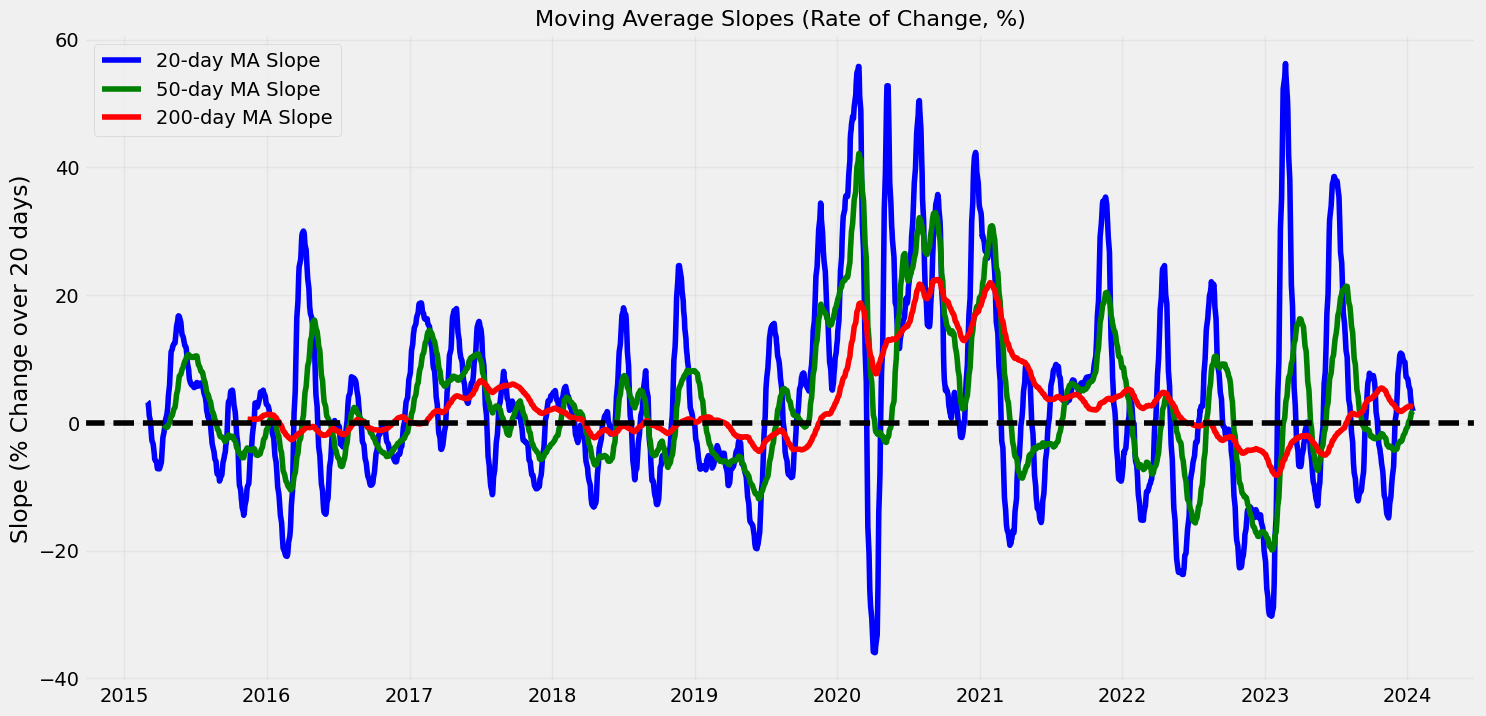

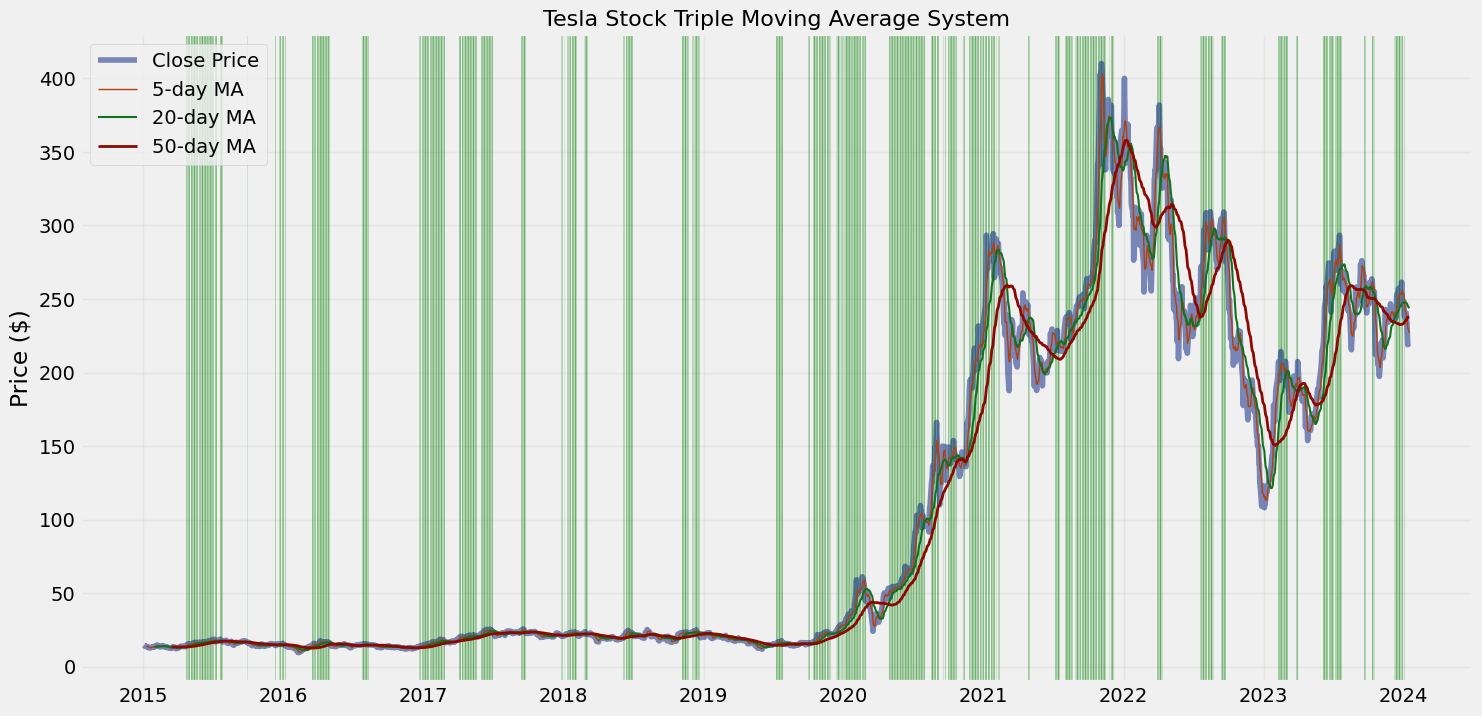

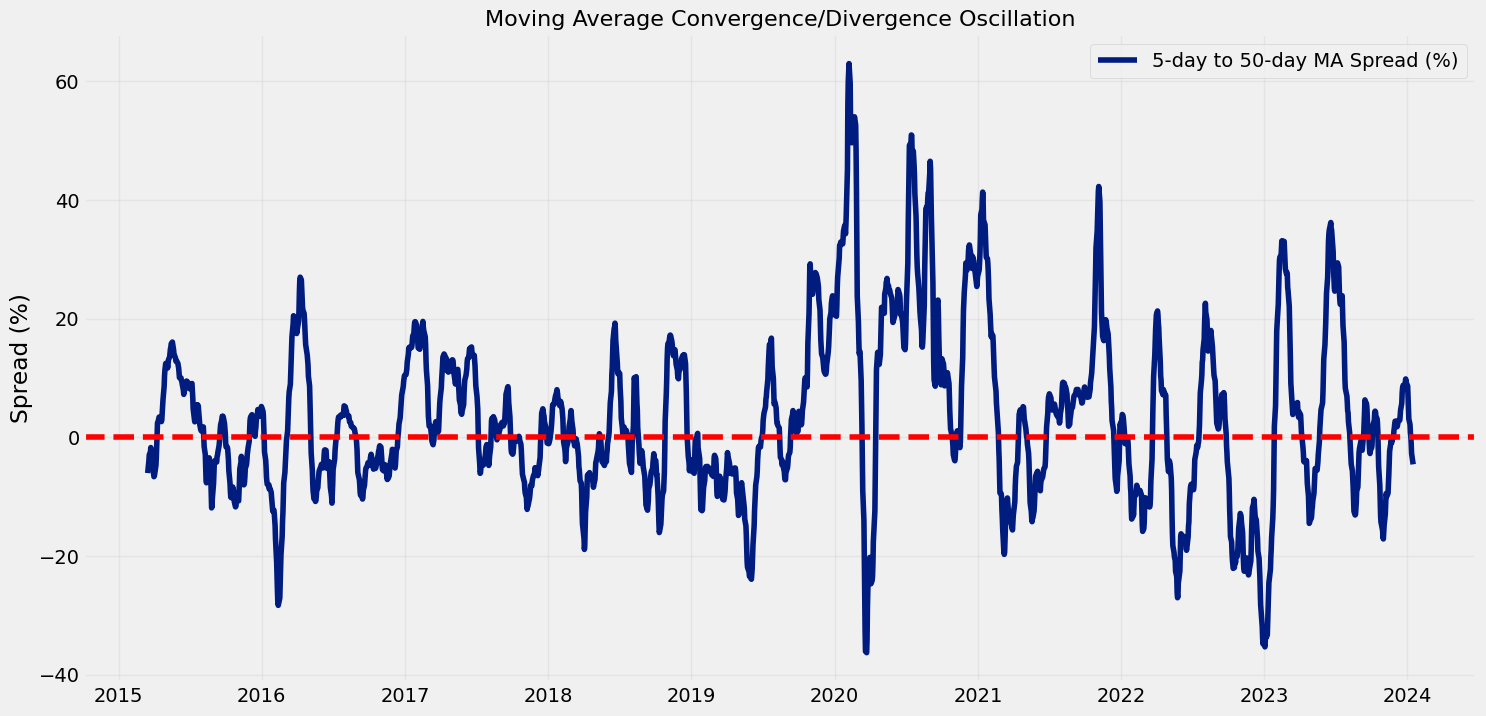

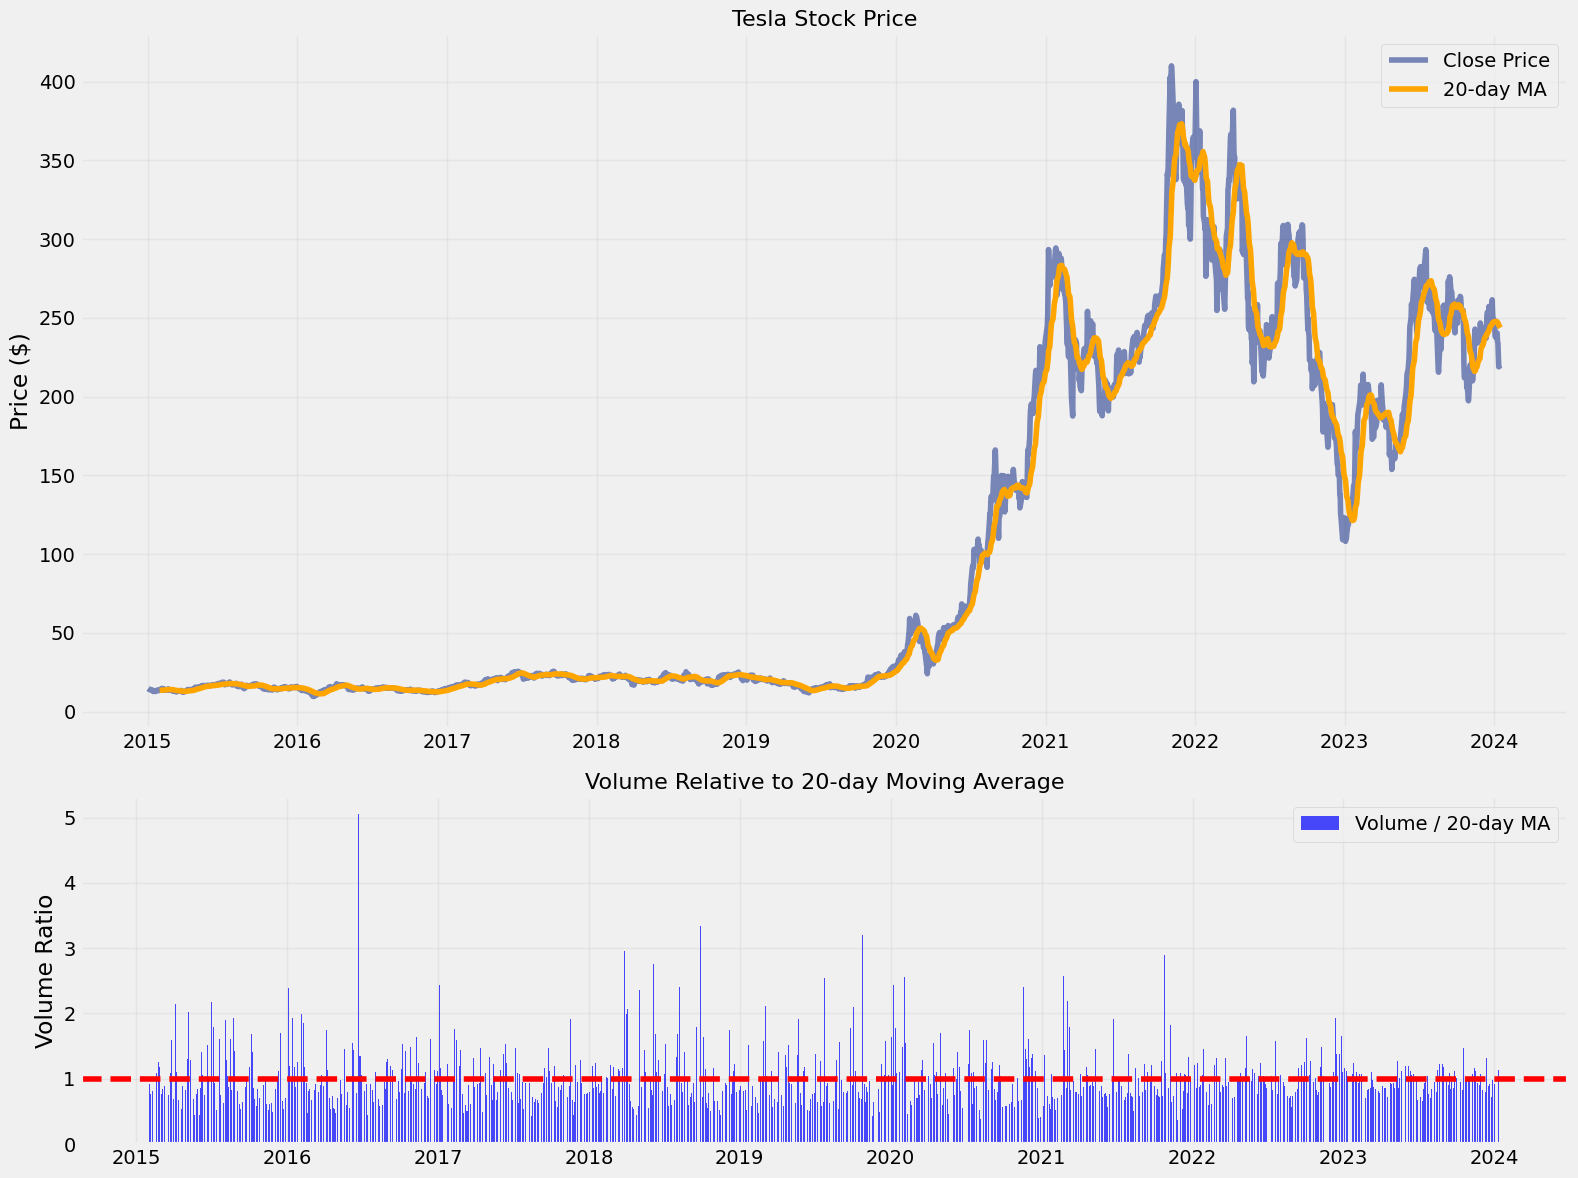

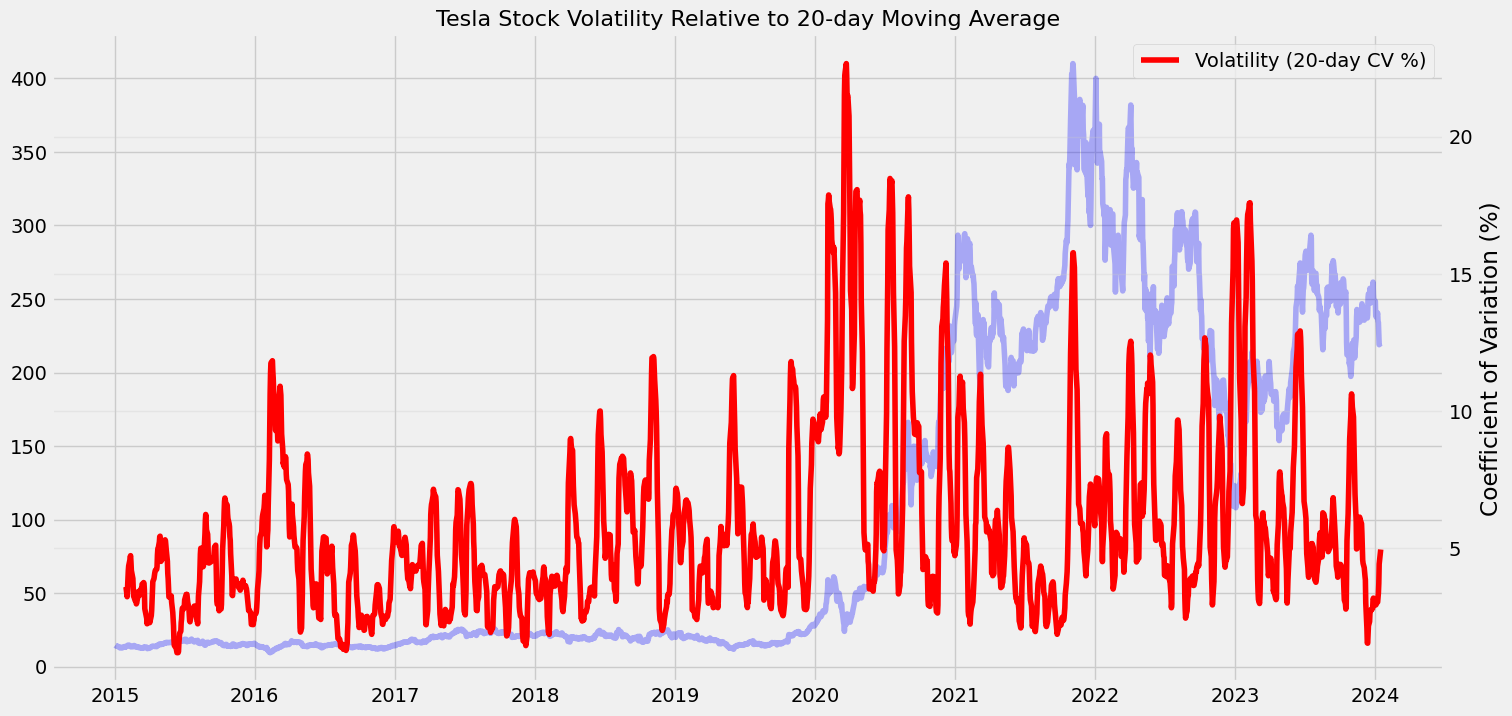

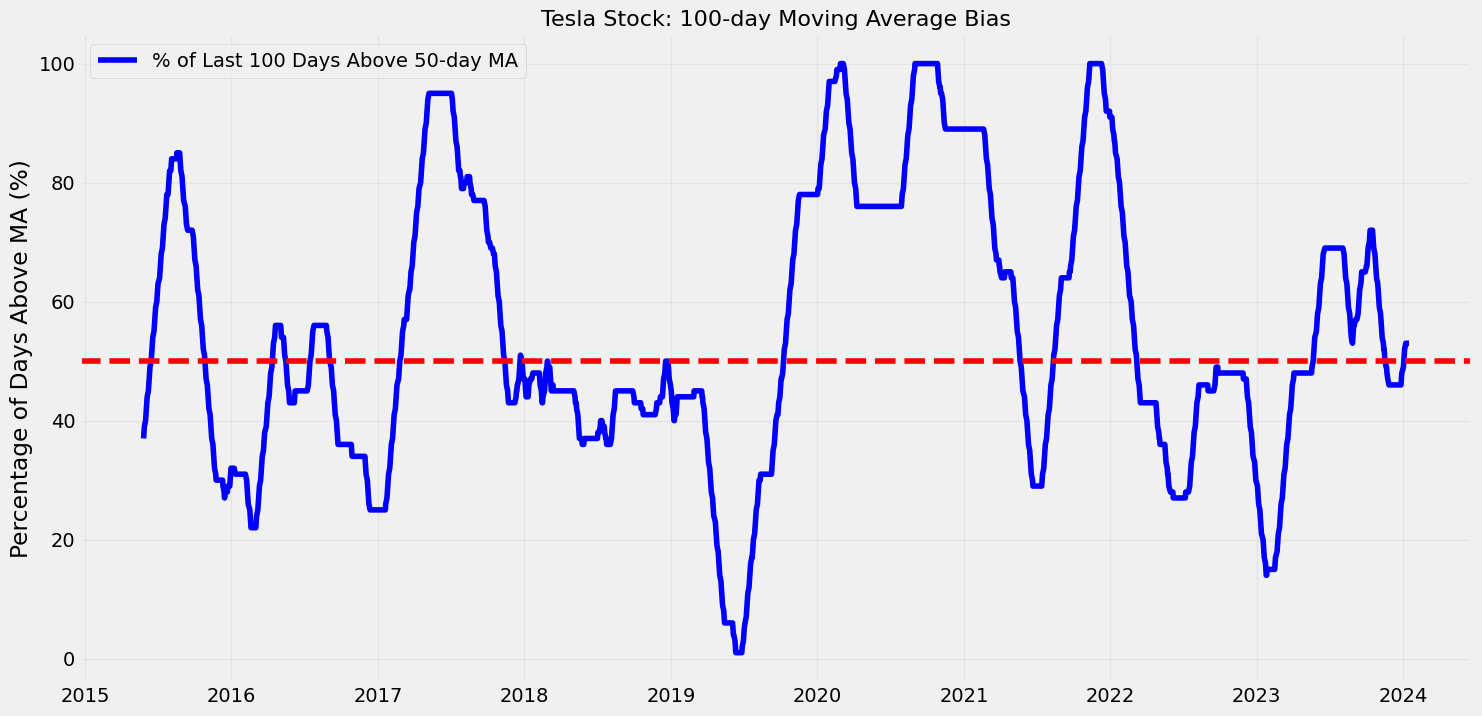

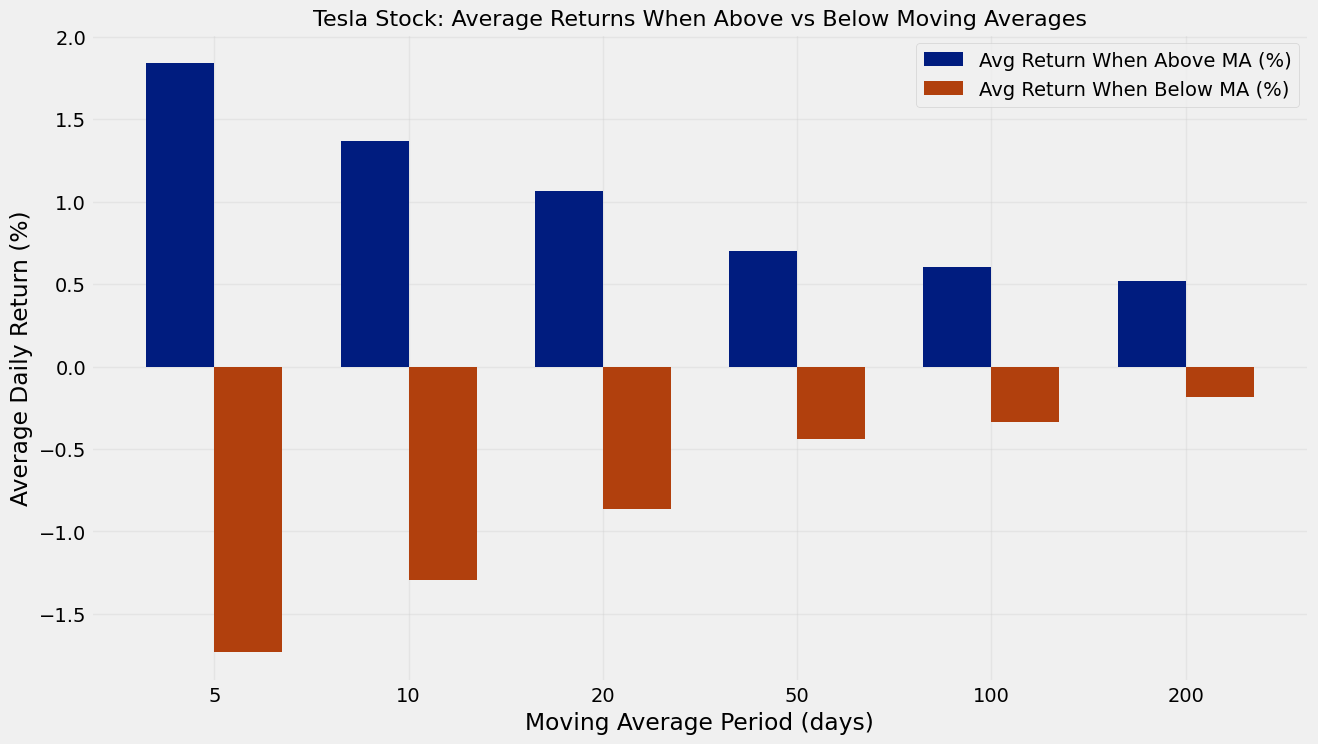

In [14]:
# 3.1 Moving Average Price Slope
# Calculate slope (rate of change) of moving averages
df['MA20_Slope'] = df['MA20'].pct_change(20) * 100  # Percentage change over 20 days
df['MA50_Slope'] = df['MA50'].pct_change(20) * 100  # Percentage change over 20 days
df['MA200_Slope'] = df['MA200'].pct_change(20) * 100  # Percentage change over 20 days

plt.figure(figsize=(16, 8))
plt.plot(df['MA20_Slope'], label='20-day MA Slope', color='blue')
plt.plot(df['MA50_Slope'], label='50-day MA Slope', color='green')
plt.plot(df['MA200_Slope'], label='200-day MA Slope', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Moving Average Slopes (Rate of Change, %)', fontsize=16)
plt.ylabel('Slope (% Change over 20 days)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3.2 Triple Moving Average Crossover System
# Signal is 1 when MA5 > MA20 > MA50
df['Triple_MA_Bull'] = (df['MA5'] > df['MA20']) & (df['MA20'] > df['MA50'])

# Plot triple MA system
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['MA5'], label='5-day MA', linewidth=1)
plt.plot(df['MA20'], label='20-day MA', linewidth=1.5)
plt.plot(df['MA50'], label='50-day MA', linewidth=2)

# Highlight bullish periods with triple MA alignment
bullish_indices = df[df['Triple_MA_Bull']].index
for i in range(len(bullish_indices) - 1):
    if (bullish_indices[i+1] - bullish_indices[i]).days > 1:  # Gap in dates
        continue
    plt.axvspan(bullish_indices[i], bullish_indices[i+1], alpha=0.2, color='green')

plt.title('Tesla Stock Triple Moving Average System', fontsize=16)
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3.3 Moving Average Convergence/Divergence Oscillation
# Calculate the spread between short and long moving averages
df['MA5_MA50_Spread'] = (df['MA5'] - df['MA50']) / df['MA50'] * 100  # Percentage spread

plt.figure(figsize=(16, 8))
plt.plot(df['MA5_MA50_Spread'], label='5-day to 50-day MA Spread (%)')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Moving Average Convergence/Divergence Oscillation', fontsize=16)
plt.ylabel('Spread (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3.4 Moving Average Trading Volume
# Calculate moving averages for volume
df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA20']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1]})

# Plot price and MA on top subplot
ax1.plot(df['Close'], label='Close Price', alpha=0.5)
ax1.plot(df['MA20'], label='20-day MA', color='orange')
ax1.set_title('Tesla Stock Price', fontsize=16)
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot volume ratio on bottom subplot
ax2.bar(df.index, df['Volume_Ratio'], label='Volume / 20-day MA', color='blue', alpha=0.7)
ax2.axhline(y=1, color='red', linestyle='--')
ax2.set_title('Volume Relative to 20-day Moving Average', fontsize=16)
ax2.set_ylabel('Volume Ratio')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3.5 Moving Average Volatility
# Calculate standard deviation of price relative to MA
df['Volatility_vs_MA20'] = df['Close'].rolling(window=20).apply(
    lambda x: np.std(x) / np.mean(x) * 100  # Coefficient of variation as percentage
)

plt.figure(figsize=(16, 8))
plt.plot(df['Close'], alpha=0.3, color='blue')
plt.twinx()  # Create a second y-axis
plt.plot(df['Volatility_vs_MA20'], color='red', label='Volatility (20-day CV %)')
plt.title('Tesla Stock Volatility Relative to 20-day Moving Average', fontsize=16)
plt.ylabel('Coefficient of Variation (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3.6 Moving Average Bias (Percentage of days above/below MA)
# Calculate 100-day bias
window = 100
df['Above_MA50'] = (df['Close'] > df['MA50']).astype(int)
df['MA50_Bias'] = df['Above_MA50'].rolling(window=window).mean() * 100  # Percentage of days price is above MA50

plt.figure(figsize=(16, 8))
plt.plot(df['MA50_Bias'], color='blue', label=f'% of Last {window} Days Above 50-day MA')
plt.axhline(y=50, color='red', linestyle='--')
plt.title(f'Tesla Stock: {window}-day Moving Average Bias', fontsize=16)
plt.ylabel('Percentage of Days Above MA (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3.7 Multiple MA System Visualization - Compare different MA periods
# Calculate average return when above/below different MAs
ma_periods = [5, 10, 20, 50, 100, 200]
ma_returns = {}

for period in ma_periods:
    ma_col = f'MA{period}'
    signal_col = f'Above_MA{period}'
    df[signal_col] = (df['Close'] > df[ma_col]).astype(int)
    
    # Calculate average daily return when above/below MA
    above_return = df.loc[df[signal_col] == 1, 'Daily_Return'].mean() * 100
    below_return = df.loc[df[signal_col] == 0, 'Daily_Return'].mean() * 100
    
    ma_returns[period] = (above_return, below_return)

# Plot results
periods = list(ma_returns.keys())
above_returns = [ma_returns[p][0] for p in periods]
below_returns = [ma_returns[p][1] for p in periods]

fig, ax = plt.subplots(figsize=(14, 8))
width = 0.35
x = np.arange(len(periods))

ax.bar(x - width/2, above_returns, width, label='Avg Return When Above MA (%)')
ax.bar(x + width/2, below_returns, width, label='Avg Return When Below MA (%)')

ax.set_xlabel('Moving Average Period (days)')
ax.set_ylabel('Average Daily Return (%)')
ax.set_title('Tesla Stock: Average Returns When Above vs Below Moving Averages', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(periods)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

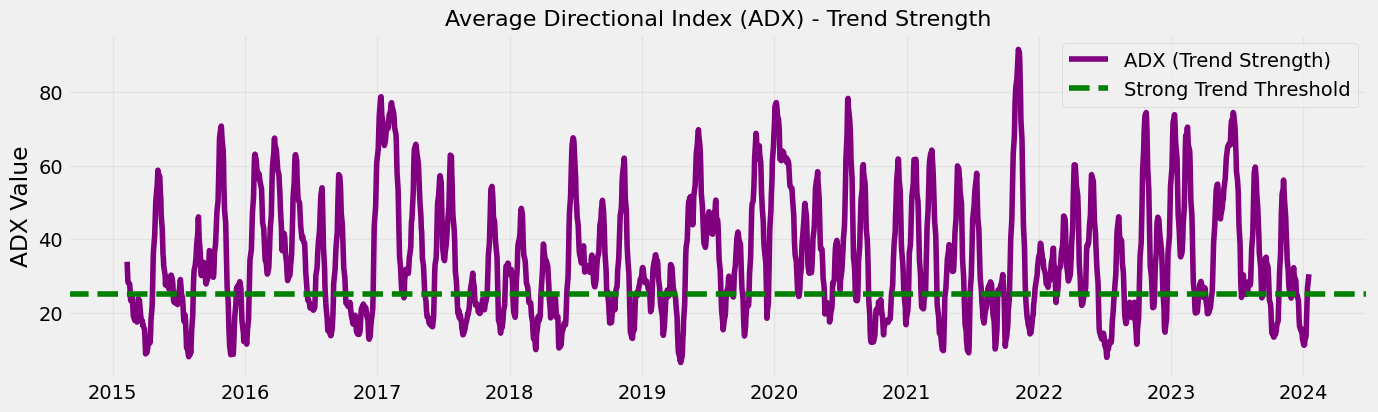

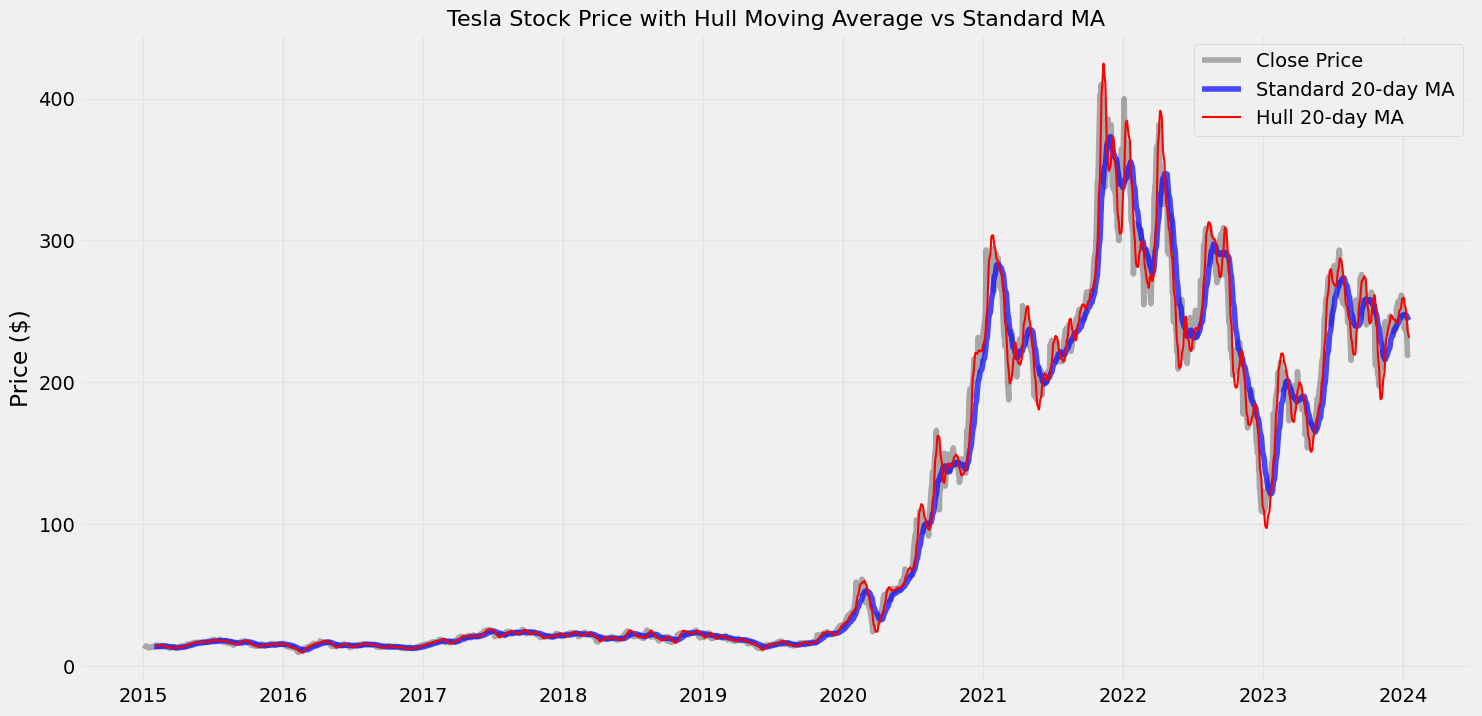

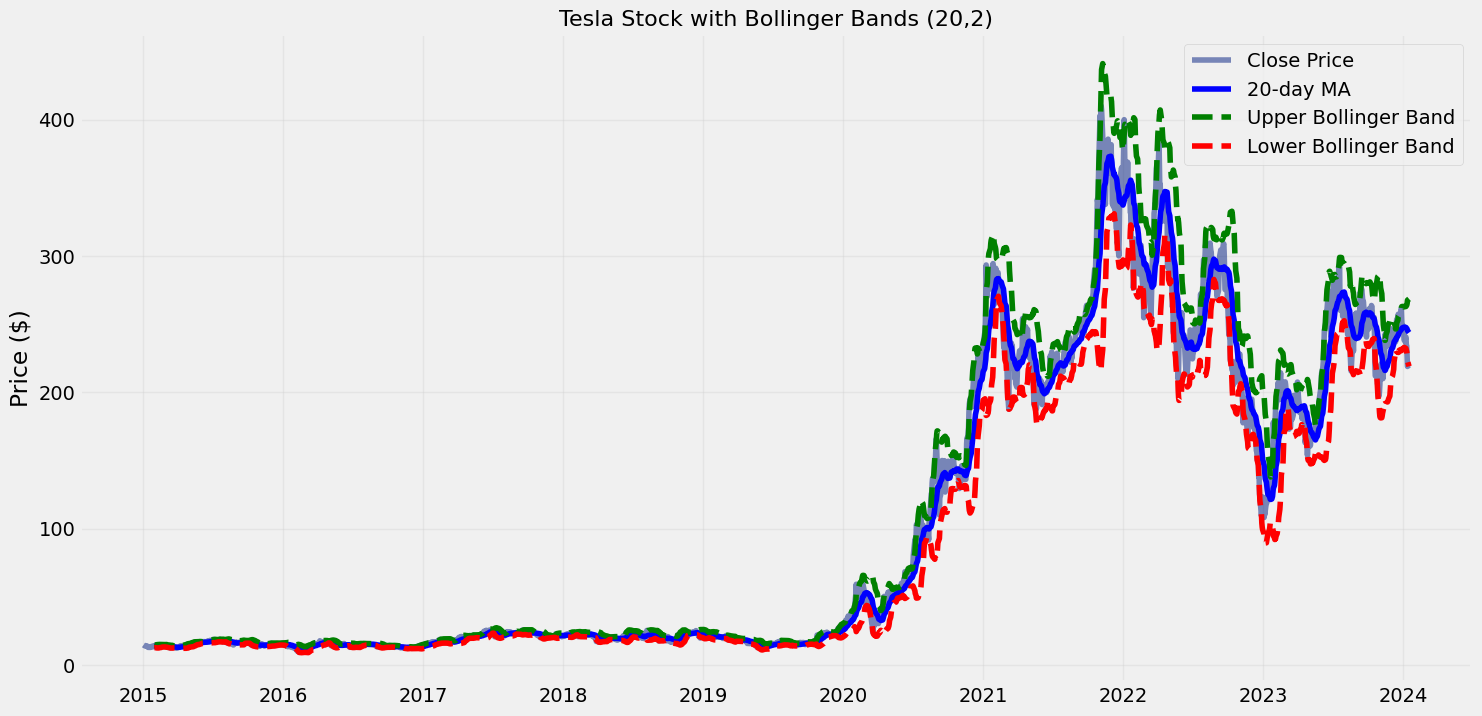

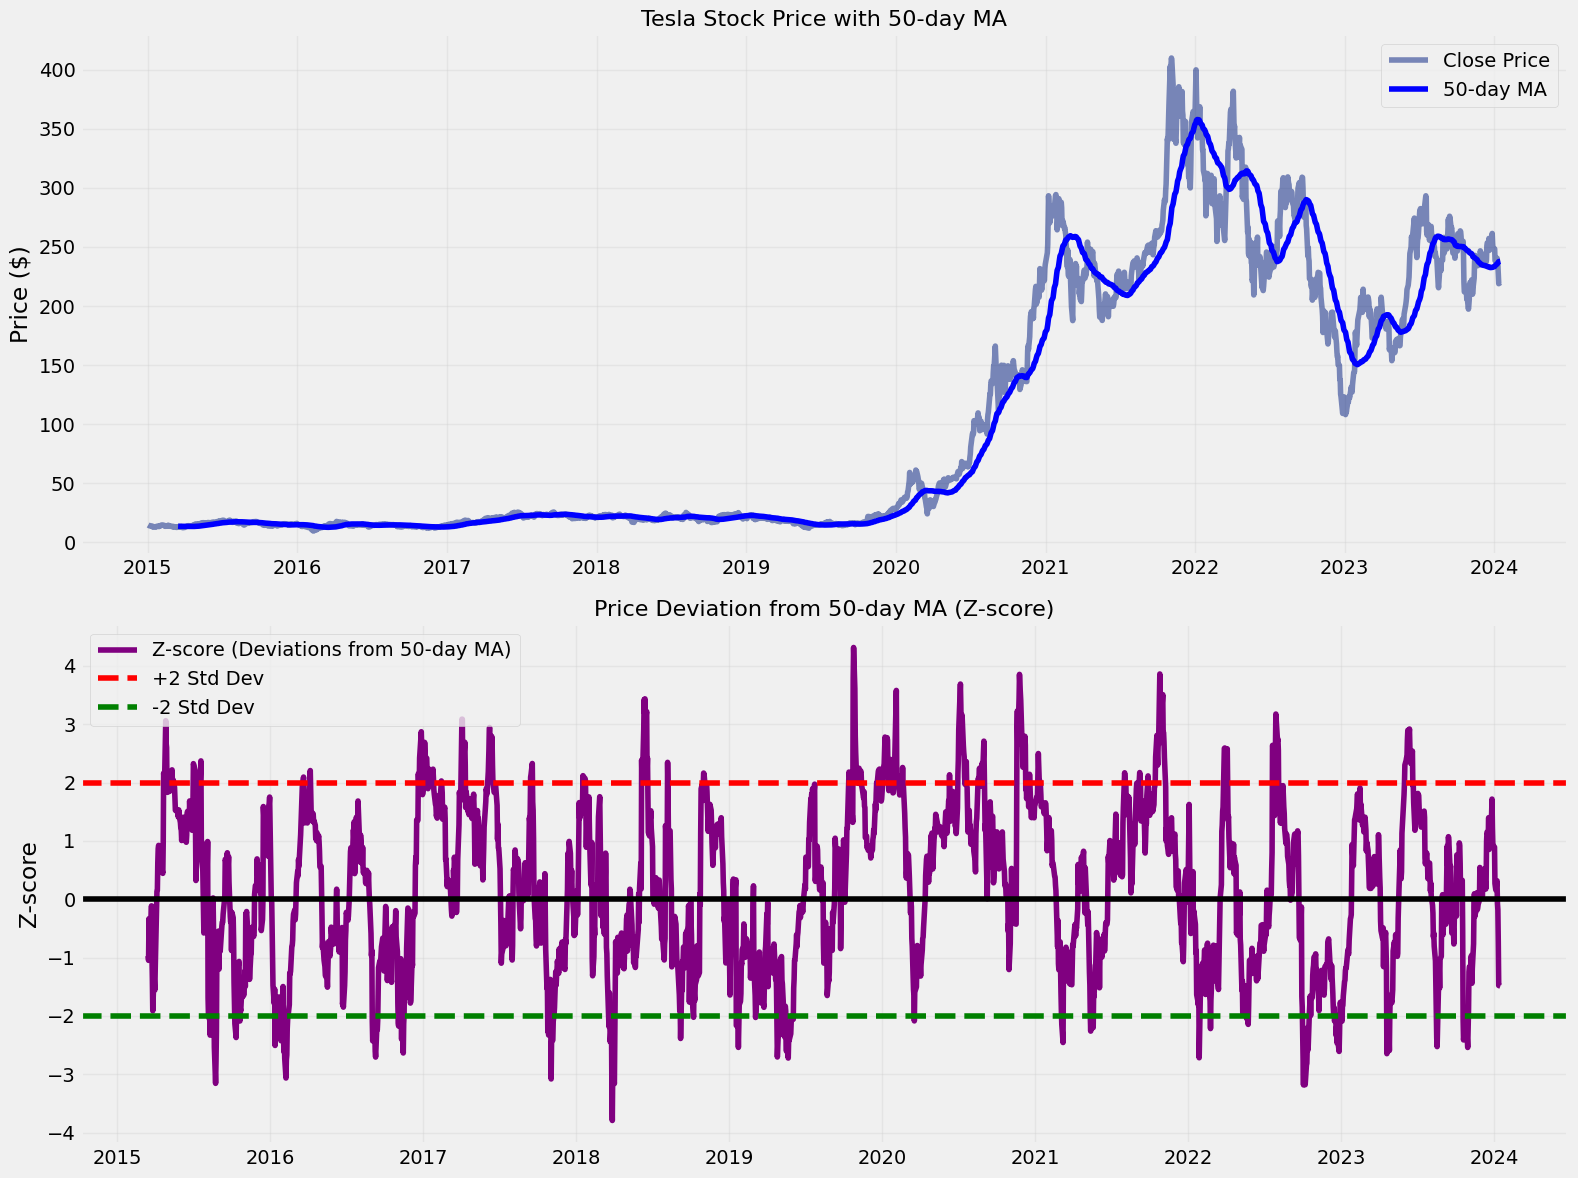

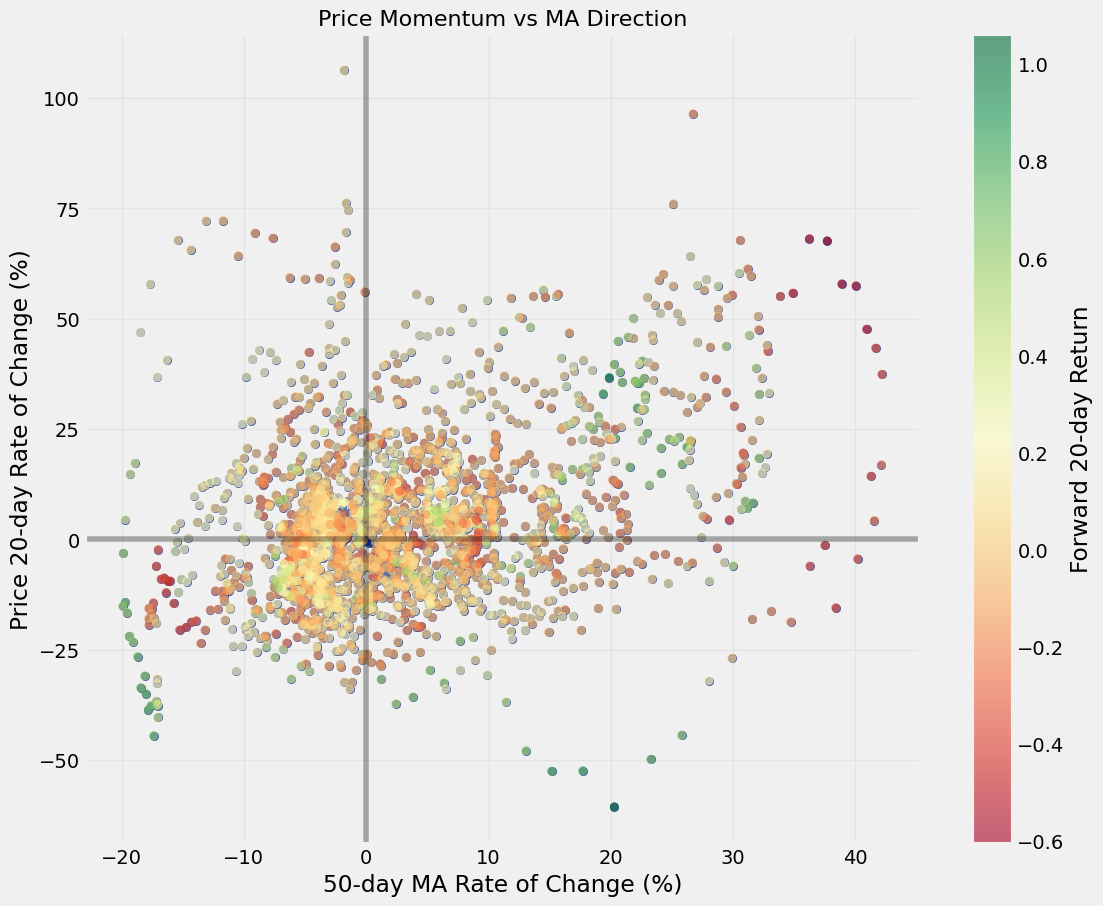

In [18]:
# 4.5 Trend Strength Analysis with Moving Averages
# Calculate ADX (Average Directional Index) components (simplified version)
window = 14

# Calculate +DI and -DI (Directional Indicators)
df['HL'] = df['High'] - df['Low']
df['HD'] = df['High'] - df['High'].shift(1)
df['LD'] = df['Low'].shift(1) - df['Low']

# +DM and -DM (Directional Movement)
df['+DM'] = np.where((df['HD'] > df['LD']) & (df['HD'] > 0), df['HD'], 0)
df['-DM'] = np.where((df['LD'] > df['HD']) & (df['LD'] > 0), df['LD'], 0)

# Calculate smoothed values
df['+DI'] = df['+DM'].rolling(window=window).sum() / df['HL'].rolling(window=window).sum() * 100
df['-DI'] = df['-DM'].rolling(window=window).sum() / df['HL'].rolling(window=window).sum() * 100

# Calculate DX (Directional Index)
df['DX'] = abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']) * 100

# Calculate ADX (Average Directional Index)
df['ADX'] = df['DX'].rolling(window=window).mean()

# # Plot ADX with Moving Averages
# plt.figure(figsize=(16, 12))

# # Price and MAs
# plt.subplot(2, 1, 1)
# plt.plot(df['Close'], label='Close Price', alpha=0.5)
# plt.plot(df['MA20'], label='20-day MA', color='blue')
# plt.plot(df['MA50'], label='50-day MA', color='red')
# plt.title('Tesla Stock Price with Moving Averages', fontsize=16)
# plt.ylabel('Price ($)')
# plt.legend()
# plt.grid(True, alpha=0.3)

# ADX
plt.subplot(2, 1, 2)
plt.plot(df['ADX'], label='ADX (Trend Strength)', color='purple')
plt.axhline(y=25, color='green', linestyle='--', label='Strong Trend Threshold')
plt.title('Average Directional Index (ADX) - Trend Strength', fontsize=16)
plt.ylabel('ADX Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4.6 Advanced Moving Average System - Hull Moving Average
# Hull Moving Average calculation
def hull_moving_average(series, window):
    # Step 1: Calculate WMA with period n/2
    half_window = int(window/2)
    wma_half = series.rolling(window=half_window).mean()
    
    # Step 2: Calculate WMA for full period
    wma_full = series.rolling(window=window).mean()
    
    # Step 3: Calculate 2 * WMA(n/2) - WMA(n)
    hull_intermediate = 2 * wma_half - wma_full
    
    # Step 4: Calculate WMA with period sqrt(n)
    sqrt_window = int(np.sqrt(window))
    hull_ma = hull_intermediate.rolling(window=sqrt_window).mean()
    
    return hull_ma

# Calculate Hull MAs
df['HMA10'] = hull_moving_average(df['Close'], 10)
df['HMA20'] = hull_moving_average(df['Close'], 20)
df['HMA50'] = hull_moving_average(df['Close'], 50)

# Plot Hull MAs compared to standard MAs
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price', alpha=0.3, color='black')
plt.plot(df['MA20'], label='Standard 20-day MA', color='blue', alpha=0.7)
plt.plot(df['HMA20'], label='Hull 20-day MA', color='red', linewidth=1.5)
plt.title('Tesla Stock Price with Hull Moving Average vs Standard MA', fontsize=16)
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4.7 Moving Average Channels
# Calculate Bollinger Bands (MA with standard deviation channels)
window = 20
std_dev = 2

df['Upper_BB'] = df['MA20'] + (df['Close'].rolling(window=window).std() * std_dev)
df['Lower_BB'] = df['MA20'] - (df['Close'].rolling(window=window).std() * std_dev)

# Plot Bollinger Bands
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['MA20'], label='20-day MA', color='blue')
plt.plot(df['Upper_BB'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(df['Lower_BB'], label='Lower Bollinger Band', color='red', linestyle='--')
plt.title('Tesla Stock with Bollinger Bands (20,2)', fontsize=16)
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4.8 Mean Reversion Analysis with Moving Averages
# Calculate Z-score (standard deviations from mean)
df['MA50_Zscore'] = (df['Close'] - df['MA50']) / df['Close'].rolling(window=50).std()

plt.figure(figsize=(16, 12))

# Price and MA
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['MA50'], label='50-day MA', color='blue')
plt.title('Tesla Stock Price with 50-day MA', fontsize=16)
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Z-score
plt.subplot(2, 1, 2)
plt.plot(df['MA50_Zscore'], label='Z-score (Deviations from 50-day MA)', color='purple')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=2, color='red', linestyle='--', label='+2 Std Dev')
plt.axhline(y=-2, color='green', linestyle='--', label='-2 Std Dev')
plt.title('Price Deviation from 50-day MA (Z-score)', fontsize=16)
plt.ylabel('Z-score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4.9 Price Momentum vs Moving Average Direction
# Calculate rate of change for price and MA
df['Price_ROC'] = df['Close'].pct_change(20) * 100  # 20-day price rate of change
df['MA50_ROC'] = df['MA50'].pct_change(20) * 100  # 20-day MA rate of change

# Create a scatter plot of price momentum vs MA direction
plt.figure(figsize=(12, 10))
plt.scatter(df['MA50_ROC'], df['Price_ROC'], alpha=0.6)

# Add colors based on return
returns = df['Close'].pct_change(20).shift(-20)  # Forward 20-day returns
plt.scatter(df['MA50_ROC'], df['Price_ROC'], c=returns, cmap='RdYlGn', alpha=0.6)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.colorbar(label='Forward 20-day Return')
plt.title('Price Momentum vs MA Direction', fontsize=16)
plt.xlabel('50-day MA Rate of Change (%)')
plt.ylabel('Price 20-day Rate of Change (%)')
plt.grid(True, alpha=0.3)
plt.show()

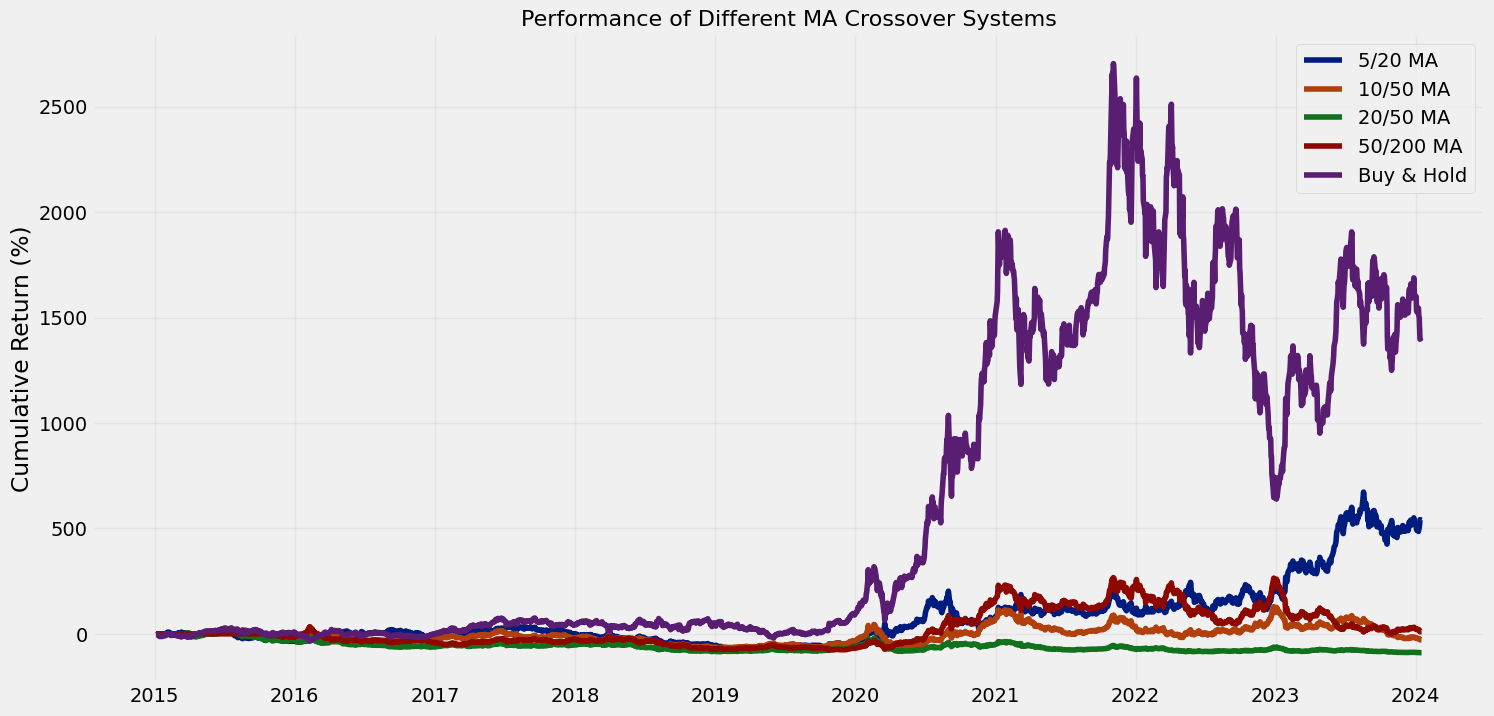


Performance Metrics for MA Crossover Systems:
            Annualized Return (%)  Volatility (%)  Sharpe Ratio  \
5/20 MA                 43.922941       56.281356      0.780417   
10/50 MA                13.014479       56.175450      0.231676   
20/50 MA                -8.198586       56.178157     -0.145939   
50/200 MA               17.913451       55.324835      0.323787   
Buy & Hold              58.205030       56.351359      1.032895   

            Max Drawdown (%)  Win Rate (%)  
5/20 MA           -79.021149     52.330695  
10/50 MA          -77.068109     50.263852  
20/50 MA          -90.348623     48.768690  
50/200 MA         -82.783247     46.745822  
Buy & Hold        -73.632217     51.802990  

Best performing system: Buy & Hold


In [16]:
# 5.1 Compare different MA crossover systems
# Define different crossover pairs
ma_pairs = [(5, 20), (10, 50), (20, 50), (50, 200)]
returns_df = pd.DataFrame(index=df.index)

# Calculate signals and returns for each pair
for short, long in ma_pairs:
    short_ma = f'MA{short}'
    long_ma = f'MA{long}'
    signal_col = f'Signal_{short}_{long}'
    
    # Create signal (1 for long, -1 for short)
    df[signal_col] = 0
    df.loc[df[short_ma] > df[long_ma], signal_col] = 1
    df.loc[df[short_ma] < df[long_ma], signal_col] = -1
    
    # Calculate strategy returns
    returns_col = f'Return_{short}_{long}'
    df[returns_col] = df[signal_col].shift(1) * df['Daily_Return']
    
    # Calculate cumulative returns
    cum_returns_col = f'Cum_Return_{short}_{long}'
    df[cum_returns_col] = (1 + df[returns_col]).cumprod() - 1
    
    # Add to returns dataframe
    returns_df[f'{short}/{long} MA'] = df[cum_returns_col]

# Add buy and hold returns
returns_df['Buy & Hold'] = (1 + df['Daily_Return']).cumprod() - 1

# Plot cumulative returns for different strategies
plt.figure(figsize=(16, 8))
for col in returns_df.columns:
    plt.plot(returns_df[col] * 100, label=col)

plt.title('Performance of Different MA Crossover Systems', fontsize=16)
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5.2 Calculate key performance metrics for each system
performance_metrics = pd.DataFrame(columns=['Annualized Return (%)', 'Volatility (%)', 
                                          'Sharpe Ratio', 'Max Drawdown (%)', 'Win Rate (%)'])

for col in returns_df.columns:
    # Calculate daily returns for the strategy
    if col == 'Buy & Hold':
        daily_returns = df['Daily_Return']
    else:
        short, long = col.split('/')[0], col.split('/')[1].split(' ')[0]
        daily_returns = df[f'Return_{short}_{long}']
    
    # Annualized return
    ann_return = (1 + daily_returns.mean()) ** 252 - 1
    
    # Annualized volatility
    ann_vol = daily_returns.std() * np.sqrt(252)
    
    # Sharpe ratio (assuming risk-free rate of 0%)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0
    
    # Maximum drawdown
    cum_returns = (1 + daily_returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max - 1)
    max_drawdown = drawdown.min()
    
    # Win rate
    win_rate = (daily_returns > 0).mean() * 100
    
    # Add to performance metrics
    performance_metrics.loc[col] = [ann_return * 100, ann_vol * 100, sharpe, max_drawdown * 100, win_rate]

print("\nPerformance Metrics for MA Crossover Systems:")
print(performance_metrics)

# 5.3 Visualize crossover signals for best performing system
# Determine best system based on Sharpe ratio
best_system = performance_metrics['Sharpe Ratio'].idxmax()
print(f"\nBest performing system: {best_system}")

# Extract MA periods from best system
if best_system != 'Buy & Hold':
    short_period, long_period = best_system.split('/')[0], best_system.split('/')[1].split(' ')[0]
    short_ma = f'MA{short_period}'
    long_ma = f'MA{long_period}'
    signal_col = f'Signal_{short_period}_{long_period}'
    
    # Plot price with MAs and signals
    plt.figure(figsize=(16, 8))
    plt.plot(df['Close'], label='Close Price', alpha=0.5)
    plt.plot(df[short_ma], label=f'{short_period}-day MA', color='blue')
    plt.plot(df[long_ma], label=f'{long_period}-day MA', color='red')
    
    # Plot buy and sell signals
    buy_signals = df[(df[signal_col] == 1) & (df[signal_col].shift(1) != 1)]
    sell_signals = df[(df[signal_col] == -1) & (df[signal_col].shift(1) != -1)]
    
    plt.scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', s=100, label='Buy Signal')
    plt.scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', s=100, label='Sell Signal')
    
    plt.title(f'Tesla Stock with {best_system} Crossover Signals', fontsize=16)
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

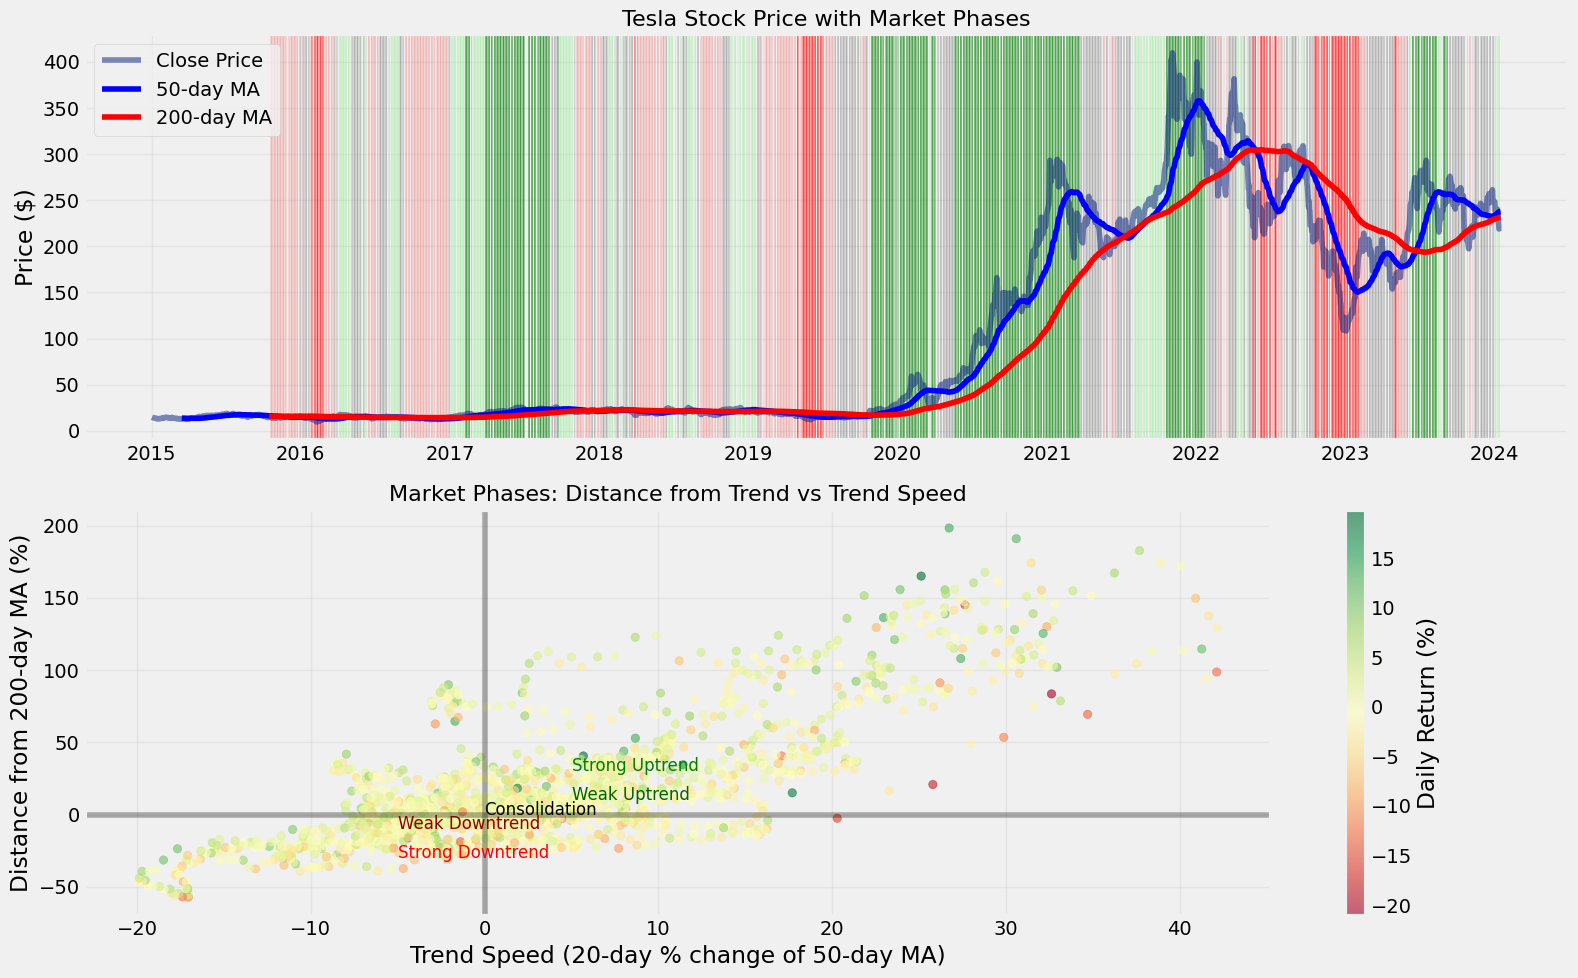


Average Daily Returns by Market Phase:
                           mean       std  count    sharpe
Market_Phase_Detailed                                     
Strong Uptrend         0.607032  4.336905  56000  0.139969
Weak Uptrend           0.285231  2.970205  31300  0.096031
Weak Downtrend         0.181418  3.101872  46600  0.058487
Consolidation         -0.078169  3.334485  56200 -0.023443
Strong Downtrend      -0.356776  4.407998  17400 -0.080938


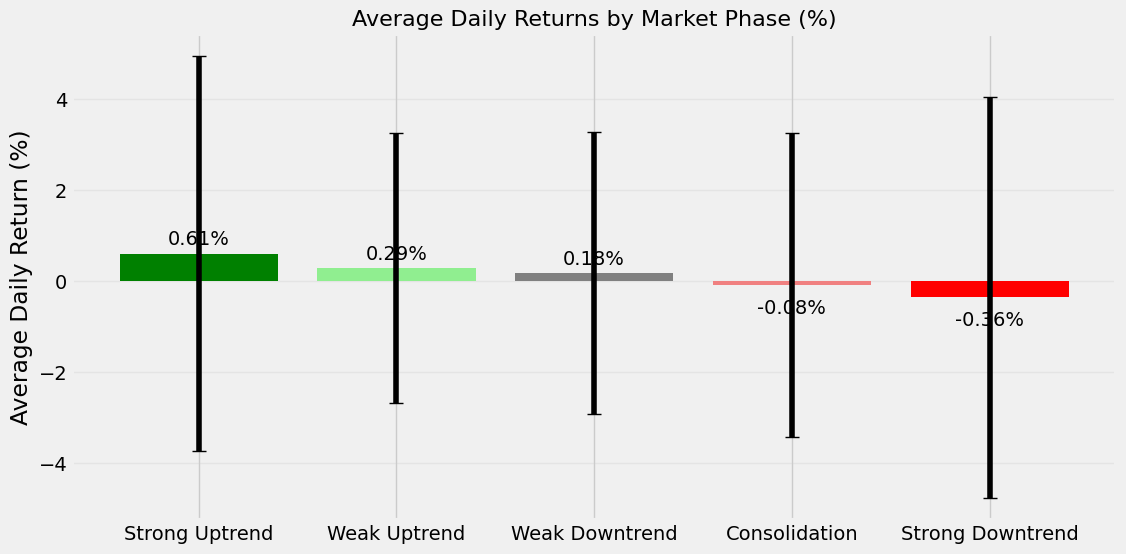

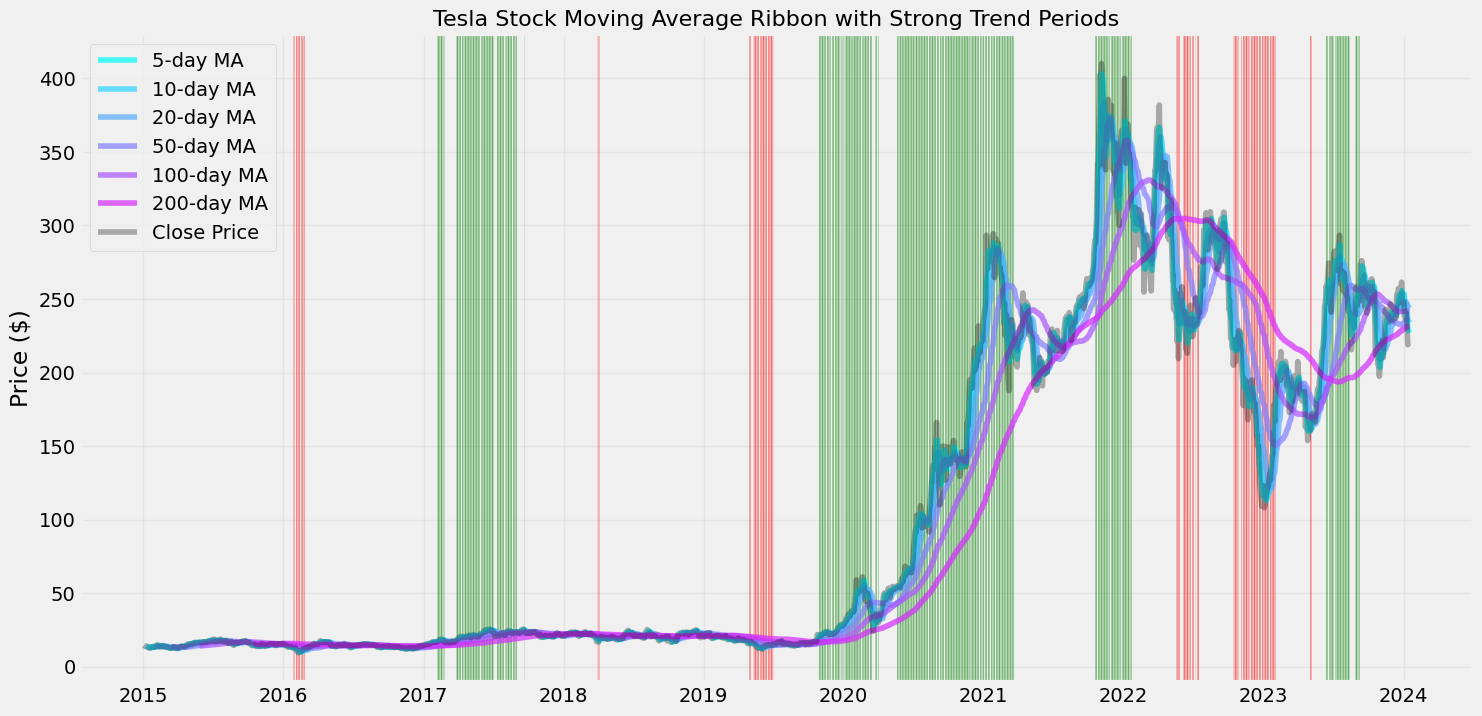

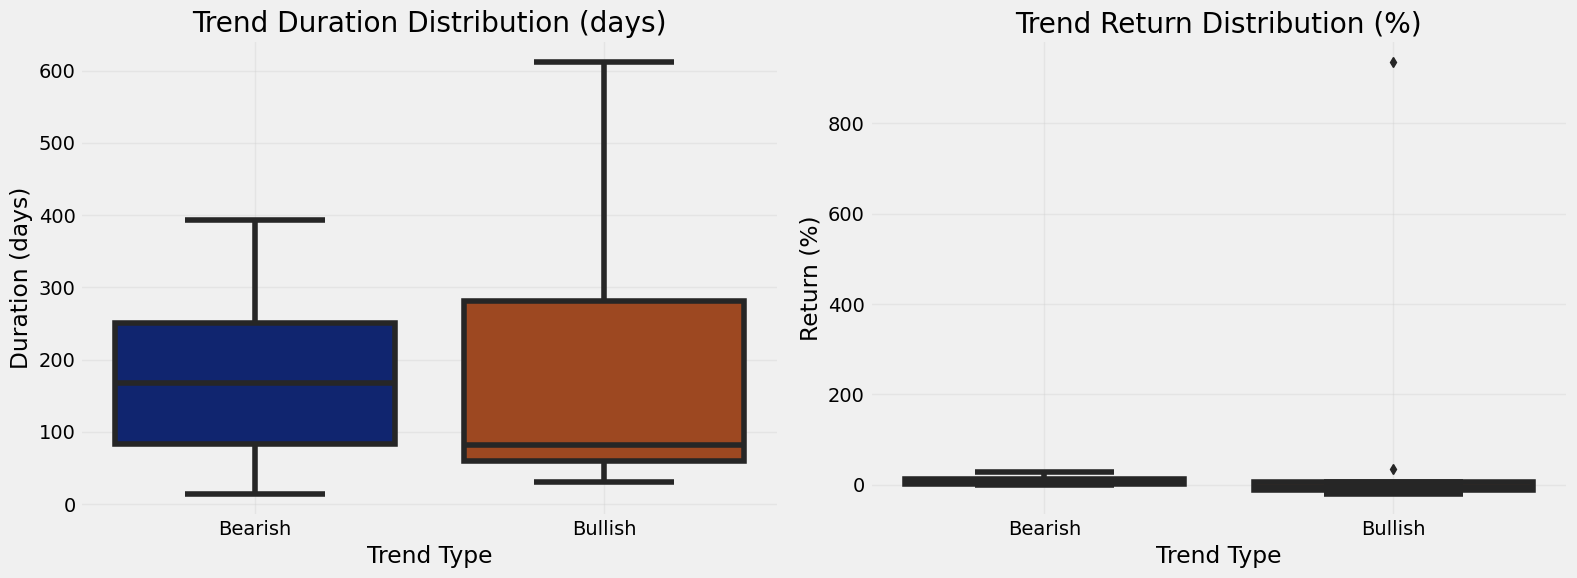


Moving Average Trend Statistics:
           Duration (days)                 Return (%)                       
                      mean min  max count        mean        min         max
Trend Type                                                                  
Bearish         177.555556  14  393     9    9.920420  -0.831555   28.288712
Bullish         187.000000  31  612     8  114.387622 -20.054932  935.480093


In [17]:
# 6.1 Trend Cycle analysis
# Identify cyclical patterns in tesla stock using moving averages
# Calculate distance from trend (MA200) and rate of change
df['Distance_From_Trend'] = (df['Close'] / df['MA200'] - 1) * 100  # % distance from 200-day MA
df['Trend_Speed'] = df['MA50'].pct_change(20) * 100  # 20-day rate of change of 50-day MA

# Classify market phases based on trend direction and distance
def classify_market_phase(row):
    if np.isnan(row['MA200']) or np.isnan(row['Distance_From_Trend']) or np.isnan(row['Trend_Speed']):
        return np.nan
    
    # Strong uptrend
    if row['Distance_From_Trend'] > 20 and row['Trend_Speed'] > 0:
        return 'Strong Uptrend'
    # Weak uptrend
    elif row['Distance_From_Trend'] > 0 and row['Distance_From_Trend'] <= 20 and row['Trend_Speed'] > 0:
        return 'Weak Uptrend'
    # Strong downtrend
    elif row['Distance_From_Trend'] < -20 and row['Trend_Speed'] < 0:
        return 'Strong Downtrend'
    # Weak downtrend
    elif row['Distance_From_Trend'] < 0 and row['Distance_From_Trend'] >= -20 and row['Trend_Speed'] < 0:
        return 'Weak Downtrend'
    # Consolidation
    else:
        return 'Consolidation'

df['Market_Phase_Detailed'] = df.apply(classify_market_phase, axis=1)

# Plot price with market phases
plt.figure(figsize=(16, 10))

# Top subplot: Price and MAs
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['MA50'], label='50-day MA', color='blue')
plt.plot(df['MA200'], label='200-day MA', color='red')

# Color background based on market phase
for phase in ['Strong Uptrend', 'Weak Uptrend', 'Consolidation', 'Weak Downtrend', 'Strong Downtrend']:
    phase_data = df[df['Market_Phase_Detailed'] == phase]
    
    if phase == 'Strong Uptrend':
        color = 'green'
        alpha = 0.3
    elif phase == 'Weak Uptrend':
        color = 'lightgreen'
        alpha = 0.2
    elif phase == 'Consolidation':
        color = 'gray'
        alpha = 0.2
    elif phase == 'Weak Downtrend':
        color = 'lightcoral'
        alpha = 0.2
    else:  # Strong Downtrend
        color = 'red'
        alpha = 0.3
    
    for i in range(len(phase_data.index) - 1):
        if (phase_data.index[i+1] - phase_data.index[i]).days > 1:  # Gap in dates
            continue
        plt.axvspan(phase_data.index[i], phase_data.index[i+1], alpha=alpha, color=color)

plt.title('Tesla Stock Price with Market Phases', fontsize=16)
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Bottom subplot: Distance from trend vs trend speed
plt.subplot(2, 1, 2)
plt.scatter(df['Trend_Speed'], df['Distance_From_Trend'], c=df['Daily_Return']*100, cmap='RdYlGn', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.colorbar(label='Daily Return (%)')
plt.title('Market Phases: Distance from Trend vs Trend Speed', fontsize=16)
plt.xlabel('Trend Speed (20-day % change of 50-day MA)')
plt.ylabel('Distance from 200-day MA (%)')
plt.grid(True, alpha=0.3)

# Add annotations for market phases
plt.annotate('Strong Uptrend', xy=(5, 30), xytext=(5, 30), fontsize=12, color='green')
plt.annotate('Weak Uptrend', xy=(5, 10), xytext=(5, 10), fontsize=12, color='darkgreen')
plt.annotate('Strong Downtrend', xy=(-5, -30), xytext=(-5, -30), fontsize=12, color='red')
plt.annotate('Weak Downtrend', xy=(-5, -10), xytext=(-5, -10), fontsize=12, color='darkred')
plt.annotate('Consolidation', xy=(0, 0), xytext=(0, 0), fontsize=12, color='black')

plt.tight_layout()
plt.show()

# 6.2 Analyze returns by market phase
phase_returns = df.groupby('Market_Phase_Detailed')['Daily_Return'].agg(['mean', 'std', 'count']) * 100
phase_returns['sharpe'] = phase_returns['mean'] / phase_returns['std']
phase_returns = phase_returns.sort_values('mean', ascending=False)

print("\nAverage Daily Returns by Market Phase:")
print(phase_returns)

# Plot average returns by market phase
plt.figure(figsize=(12, 6))
colors = ['green', 'lightgreen', 'gray', 'lightcoral', 'red']
bars = plt.bar(phase_returns.index, phase_returns['mean'], yerr=phase_returns['std'], 
       capsize=5, color=colors[:len(phase_returns)])

plt.title('Average Daily Returns by Market Phase (%)', fontsize=16)
plt.ylabel('Average Daily Return (%)')
plt.grid(True, alpha=0.3, axis='y')

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.3),
             f'{height:.2f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.show()

# 6.3 Moving Average Ribbon and Market Phase Combined Analysis
# Plot MA ribbon and market phase
plt.figure(figsize=(16, 8))

# Plot ribbons with gradient color
color_map = plt.cm.cool
ma_periods = [5, 10, 20, 50, 100, 200]
for i, period in enumerate(ma_periods):
    ma_col = f'MA{period}'
    color = color_map(i / len(ma_periods))
    plt.plot(df[ma_col], label=f'{period}-day MA', color=color, alpha=0.7)

# Plot price
plt.plot(df['Close'], label='Close Price', color='black', alpha=0.3)

# Add strong trend periods
strong_up = df[df['Market_Phase_Detailed'] == 'Strong Uptrend'].index
strong_down = df[df['Market_Phase_Detailed'] == 'Strong Downtrend'].index

# Highlight strong trend periods
for i in range(len(strong_up) - 1):
    if (strong_up[i+1] - strong_up[i]).days > 1:
        continue
    plt.axvspan(strong_up[i], strong_up[i+1], alpha=0.2, color='green')

for i in range(len(strong_down) - 1):
    if (strong_down[i+1] - strong_down[i]).days > 1:
        continue
    plt.axvspan(strong_down[i], strong_down[i+1], alpha=0.2, color='red')

plt.title('Tesla Stock Moving Average Ribbon with Strong Trend Periods', fontsize=16)
plt.ylabel('Price ($)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 6.4 MA Trend Persistence - How long trends last
# Calculate trend persistence (days in same direction)
df['MA_50_200_Cross'] = np.where(df['MA50'] > df['MA200'], 1, -1)
df['Trend_Change'] = df['MA_50_200_Cross'] != df['MA_50_200_Cross'].shift(1)
df['Trend_Duration'] = 0

# Calculate trend duration
trend_start = 0
current_trend = None

for i in range(len(df)):
    if i == 0 or df.iloc[i]['Trend_Change']:
        trend_start = i
        current_trend = df.iloc[i]['MA_50_200_Cross']
    
    df.iloc[i, df.columns.get_loc('Trend_Duration')] = i - trend_start

# Extract completed trends
trend_changes = df[df['Trend_Change']].index
trend_durations = []
trend_types = []
trend_returns = []

for i in range(1, len(trend_changes)):
    start_date = trend_changes[i-1]
    end_date = trend_changes[i]
    
    trend_type = 'Bullish' if df.loc[start_date:end_date, 'MA_50_200_Cross'].iloc[0] == 1 else 'Bearish'
    duration = (end_date - start_date).days
    returns = (df.loc[end_date, 'Close'] / df.loc[start_date, 'Close'] - 1) * 100
    
    trend_types.append(trend_type)
    trend_durations.append(duration)
    trend_returns.append(returns)

# Create trend summary dataframe
trends_df = pd.DataFrame({
    'Trend Type': trend_types,
    'Duration (days)': trend_durations,
    'Return (%)': trend_returns
})

# Plot trend durations and returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Duration boxplot
sns.boxplot(x='Trend Type', y='Duration (days)', data=trends_df, ax=ax1)
ax1.set_title('Trend Duration Distribution (days)')
ax1.grid(True, alpha=0.3)

# Return boxplot
sns.boxplot(x='Trend Type', y='Return (%)', data=trends_df, ax=ax2)
ax2.set_title('Trend Return Distribution (%)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print trend statistics
print("\nMoving Average Trend Statistics:")
print(trends_df.groupby('Trend Type').agg({
    'Duration (days)': ['mean', 'min', 'max', 'count'],
    'Return (%)': ['mean', 'min', 'max']
}))